In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

import requests
import time
import ast
import random

# Spotipy
from dotenv import load_dotenv
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

In [2]:
# import the dataframes
df_uk_masters = pd.read_csv('Datasets/df_uk_masters.csv')                         # all the albums from the UK
df_us_masters = pd.read_csv('Datasets/df_us_masters.csv')                         # albums from the US until 1996, 1998 and 2000
df_us_new_masters = pd.read_csv('Datasets/df_us_new_masters.csv')                         # albums from the US from 1997, 1999 and 2001
df_ratings_20 = pd.read_csv('Datasets/df_ratings_20.csv', keep_default_na=False)  # albums with >= 20 votes, mostly from rock, worldwide
df_ratings_10 = pd.read_csv('Datasets/df_ratings_10.csv', keep_default_na=False)  # albums with >= 10 votes, mostly from rock, worldwide
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (until 2000) with >= 20 votes 

# print information
print(f'{df_uk_masters.shape}: df_uk_masters')
print(f'{df_us_masters.shape}: df_us_masters')
print(f'{df_us_new_masters.shape}: df_us_new_masters')
print(f'{df_ratings_20.shape}: df_ratings_20')
print(f'{df_ratings_10.shape}: df_ratings_10')
print(f'{df_masters_blended.shape}: df_masters_blended')

(56660, 13): df_uk_masters
(48690, 13): df_us_masters
(52399, 13): df_us_new_masters
(51222, 5): df_ratings_20
(79625, 5): df_ratings_10
(9667, 13): df_masters_blended


# **``country``**

In [15]:
df_artists_origins = pd.read_csv('Datasets/df_artists_origins.csv')                             # df with only the bands and their city of origin
df_coordinates = pd.read_csv('Datasets/df_coordinates.csv')                                     # df with the full info of the locations (coordinates)
df_artists_origins_coordinates = pd.read_csv('Datasets/df_artists_origins_coordinates.csv')     # merge of the bands with the full info of the locations (coordinates)

# print information
print(f'{df_artists_origins.shape}: df_artists_origins')
print(f'{df_coordinates.shape}: df_coordinates')
print(f'{df_artists_origins_coordinates.shape}: df_artists_origins_coordinates')
print(f'{df_masters_blended.shape}: df_masters_blended')

(4888, 2): df_artists_origins
(2091, 7): df_coordinates
(4888, 6): df_artists_origins_coordinates
(11920, 13): df_masters_blended


In [21]:
# df with only the bands and their city of origin
df_artists_origins.head(2)

,artist,origin
0,Sparta,"El Paso, Texas"
1,Muse,"Teignmouth, Devon, England"


In [22]:
# df with the full info of the locations (coordinates)
df_coordinates.head(2)

,country,city,origin,origin_clean,latitude,longitude,address
0,Argentina,Buenos Aires,"Buenos Aires, Argentina","Buenos Aires, Argentina",-34.608370,-58.444058,"Buenos Aires, Comuna 6, Ciudad Autónoma de Bue..."
1,Australia,Adelaide,"Adelaide, South Australia, Australia","Adelaide, South Australia, Australia",-34.928181,138.599931,"Adelaide, Adelaide City Council, South Austral..."


In [23]:
# merge of the bands with the full info of the locations (coordinates)
df_artists_origins_coordinates.head(2)

,artist,country,city,latitude,longitude,address
0,Sparta,United States,El Paso,31.760116,-106.48704,"El Paso, El Paso County, Texas, United States"
1,Muse,United Kingdom,Teignmouth,50.546338,-3.49578,"Teignmouth, Teignbridge, Devon, England, Unite..."


In [20]:
# albums from the UK and US (until 2000) with >= 20 votes
df_masters_blended.head(2)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.0,13,['Album'],['Rock'],"['Alternative Rock', 'Pop Punk']","Band from Dover Plains, New York, formerly kno..."


## **Looking for extra artists in one df and not in the other one**

### ``extra_artists``: artists with less than 20 votes (but more than 10)

So I started looking for the origins of the band from from a merge with ``df_ratings_10``, but there were too many bands without correct information of the location, so I decided to limit the dataset merging it with ``df_ratings_20``, so I would drop the albums with >= 10 votes but less than 20 votes.

In [27]:
df_masters_blended['artist'].nunique()

4530

In [28]:
df_artists_origins['artist'].nunique()

4888

In [110]:
extra_artists = []

for i in df_artists_origins['artist'].unique():
    if i not in df_masters_blended['artist'].unique():
        extra_artists.append(i)

len(extra_artists)

646

In [59]:
random.sample(extra_artists, 10)

['Early Man',
 'Gore',
 'BulletBoys',
 'Mice Parade',
 'Duke Special',
 'Vain',
 'Pentangle',
 'Brightblack Morning Light',
 'Young Statues',
 'Spermbirds']

In [108]:
artist = 'Brightblack Morning Light'

if artist in df_artists_origins['artist'].values:
    print(f"'{artist}' in df_artists_origins")
if artist in df_ratings_10['artist'].values:
    print(f"'{artist}' in df_ratings_10")
if artist in df_ratings_20['artist'].values:
    print(f"'{artist}' in df_ratings_20")
if artist in df_masters_blended['artist'].values:
    print(f"'{artist}' in df_masters_blended")    

'Brightblack Morning Light' in df_artists_origins
'Brightblack Morning Light' in df_ratings_10


In [109]:
df_ratings_10[df_ratings_10['artist']=='BulletBoys']

,album_id,artist,title,rating,votes
32694,63581,BulletBoys,BulletBoys,3.5,18


For instance the band 'BulletBoys' has only one album with 18 votes, and the rest of the albums, less votes.

https://www.sputnikmusic.com/bands/BulletBoys/22593/

My assumptions were correct, **I can drop these ``extra_artists`` from ``df_artists_origins``**

In [ ]:
df_artists_origins.shape

(4888, 2)

In [ ]:
# testing before committing
df_artists_origins[~df_artists_origins['artist'].isin(extra_artists)].shape

(4242, 2)

In [ ]:
len(extra_artists) == df_artists_origins.shape[0] - df_artists_origins[~df_artists_origins['artist'].isin(extra_artists)].shape[0]

True

In [ ]:
df_artists_origins = df_artists_origins[~df_artists_origins['artist'].isin(extra_artists)]
df_artists_origins.shape

(4242, 2)

### Artists in ``artists_to_remove``, from outside the UK or US

In [146]:
abroad_artists = []

for i in df_masters_blended['artist'].unique():
    if i not in df_artists_origins['artist'].unique():
        abroad_artists.append(i)

len(abroad_artists)

288

These are the artists that I dropped while getting the location and I realised they were not from the UK or US, from the list ``artists_to_remove``

In [112]:
artists_to_remove = ['Cemetery Skyline', 'Goat', 'Kingcrow', 'Speed', 'Hyperdontia', 'Vredehammer', 'Weston Super Maim',
                    'Mdou Moctar', 'AVRALIZE', 'Engulfed', 'Coffin Storm', 'samlrc', 'Little Kid', 'Termina', 'Rorcal',
                    'Reverence To Paroxysm', 'Voyager', 'Blindfolded and Led to the Woods', 'Mork', 'Yeule', 'Pond',
                    'Empire State Bastard', 'Blood Command', 'Avatar', 'Brutus', 'Faceless Burial', 'Within Destruction',
                    'Sedimentum', 'Ataraxy', 'Corpsessed', 'Epitaphe', 'Aldous Harding', 'Messa', 'Ghost', 'Ecchymosis',
                    'Wormrot', 'Vertebra Atlantis', 'Papangu', 'Sermon of Flames', 'Springtime', 'Monolord', 'Sulphurous',
                    'LLNN', 'Trna', 'Slaughter To Prevail', 'sonhos tomam conta', 'Galvanizer', 'Ophidian I', 'Diabolizer',
                    'Morbific', 'Defacement', 'Divide And Dissolve', 'Soen', 'Scorpions', 'Accept', 'Respire', 'Undergang',
                    'Bearings', 'Scalp', 'Miasmatic Necrosis', 'Teenage Mutant Ninja Turtles', 'Gorephilia', 'Vous Autres',
                    'Carnation', 'Pharmacist', 'Paara', "Justice For The Damned", 'VVilderness', 'Molested Divinity', 'Ellis',
                     'Kontinuum', 'Monsters', 'Giver', 'Lowrider', 'Vengeful Spectre', 'Vomit the Soul', 'Sadisme', 'Alarmist',
                     'Klone', 'Nocturnal Departure', 'King Gizzard and The Lizard Wizard', 'Make Them Suffer', 'The Chats',
                     'Patrick Watson', 'Shirokuma', 'Forests', 'Town Portal', 'Ceremony Of Silence', 'CHAI', 'Baalsebub',
                     'Minors', 'Mono', 'Tallies', 'Normandie', 'Mouse On The Keys', 'Burial Invocation', 'Orville Peck',
                     'Lunatic Soul', 'Alex Lahey', 'Hozier', 'Mystifier', 'Hands Like Houses', 'Ruins', 'Autokrator',
                     'Legend of the Seagullmen', 'Death Toll 80k', 'IDYLLS', 'Spaceslug', 'i hate sex', 'Band-Maid',
                     'With the Dead', 'Hungry Ghosts', 'Middle Kids', 'Gleb Kolyadin', "Leaves' Eyes", "Phrenelith",
                     "David Brent", "Art Of Dying", "Minor Victories", "Pantha Du Prince", "Schammasch", 'LUH',
                     'Violet Cold', 'EL VY', 'Shining', 'Hills', "Mutiny On The Bounty", 'Lucifer', 'FFS', 'Ranger',
                     'Trepalium', 'A Textbook Tragedy', 'This Is A Standoff', 'FACT', 'Swallowed', 'Disembarked',
                     'Wildbirds and Peacedrums', 'Archivist', 'Timber Timbre', 'Newsboys', 'Dope Lemon', 'Vagabon',
                     'RY X', 'Moonlit Sailor', 'The Drones', 'Sarah Neufeld', 'Say Lou Lou', 'Cruciamentum', 'Lay Down Rotten',
                     'Dreamshade', 'Sickening Gore', 'Circles', "Avey Tare's Slasher Flicks", 'Forest Silence',
                     "One Eyed God Prophecy", 'Coffins', 'Osamu Kitajima', 'Living With Lions', 'Ansur', 'Parades',
                     "Intestine Baalism", 'Comity', 'No Omega', 'Wolverine', 'Disavowed', 'Angel Dust', "!T.O.O.H.!",
                     'Hypnosia', 'Hexenhaus', 'Paradox', 'Deathrow', 'Excruciate', 'FareWell Poetry', 'Sights and Sounds',
                     'Supersister', "Birds Of Tokyo", 'Ark', "The Flower Kings", 'Beardfish', 'Graveworm', 'Acid',
                     'Ladyhawke', 'Geddy Lee', 'Yngwie Malmsteen', "World's End Girlfriend", 'Totem Skin', 'Lewis',
                     'I Hate Sally', "The Band", 'Lisa Hannigan', 'Lethal', 'Bubu', 'Van She', 'Mooncake', 'The Haunted',
                     "Orphaned Land", 'Madder Mortem', 'Kataxu', 'Gilberto Gil', 'Vendetta', 'Kvist', 'Acrostichon', 'Pain',
                     'Obliteration', 'Flames of Hell', 'Wombbath', 'Stone', 'Disgrace', 'Fionn Regan', 'Disastrous Murmur',
                     'Urfaust', 'Sleepingdog', 'Island', 'Bethlehem', 'Subterranean Masquerade', 'After Dinner', 
                     'Black Boned Angel', 'FM', 'Embrace', 'Solefald', 'Maneige', 'Amberian Dawn', 'OOIOO', 'Anekdoten',
                     "Aphrodite's Child", 'Hollenthon', 'Lykke Li', 'Lenka', 'Sarah McLachlan', 'Owen Pallett',
                     'Devin Townsend Project', 'Missy Higgins', 'The Devin Townsend Band', 'Selda', 'Massacra', "Rory Gallagher",
                     'Taste', 'Celestial Season', 'Ida Maria', 'Dark Tranquillity', 'Cadaver', 'Pele', 'Exuma',
                     'Great Lake Swimmers', 'Dawn', 'The Bats', 'Yoko Ono', 'Illogicist', 'The Saints', 'Final Fantasy',
                     'Pendulum', 'Lunar Aurora', 'Bee Gees', 'Stars', "David Sylvian and Robert Fripp", 'Afflicted', 'Lengsel',
                     'Extol', 'MDFMK', 'Univers Zero', 'Mortuary Drape', 'Zyklon', 'Winds', 'Zyklon-B', 'The Sins of Thy Beloved',
                     'Lords of Acid', 'Devin Townsend', 'Diablo Swing Orchestra', 'Arcturus', 'Cornelius', 'Manu Chao',
                     'Bryan Adams', 'Peaches', 'Doro', 'Kingdom Come', 'Pekka Pohjola', 'Shakira', 'Massacre', 'Subhumans',
                     'Set Fire to Flames', 'Gorgoroth', 'Gandalf', 'Klaus Schulze', 'The Ecstasy of Saint Theresa',
                     "Lou Reed and John Cale", 'Brian Eno and David Byrne', 'Bob Dylan and The Band', 'Era', 'Devil Doll']

In [54]:
random.sample(abroad_artists, 10)

['Acid',
 'Undergang',
 'Dreamshade',
 'IDYLLS',
 '!T.O.O.H.!',
 'Gandalf',
 'Voyager',
 'VVilderness',
 'Acrostichon',
 'Bee Gees']

In [ ]:
# it shouldn't print anything
for i in abroad_artists:
    if i not in artists_to_remove:
        print("Where does this artist come from?")

In [159]:
# to visually inspect these artists
df_masters_blended[~df_masters_blended['artist'].isin(df_artists_origins['artist'])].sample(5)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
5222,271475,179341,625410,Europe,Accept,Staying A Life,1990,96.30,19,['Album'],['Rock'],['Heavy Metal'],German heavy metal band from the town of Solin...
3587,1523898,355802,5641086,Canada,Sights and Sounds,Monolith,2009,57.22,13,['Album'],['Rock'],"['Post Rock', 'Hardcore', 'Punk']","Toronto (Ontario, Canada) based rock outfit."
3396,254199,383012,3377804,US,The Band,High On The Hog,1996,46.95,10,['Album'],['Rock'],[],Canadian-American roots rock group. Gradually ...
3822,252164,320738,4838619,UK & Europe,The Haunted,Unseen,2011,42.35,12,['Album'],['Rock'],"['Thrash', 'Hardcore', 'Death Metal']","Swedish melodic death metal band, formed in 19..."
2933,1179900,482184,2584388,Canada,I Hate Sally,Don't Worry Lady,2006,0.00,10,['Album'],['Rock'],"['Post-Hardcore', 'Metalcore']","Canadian metalcore band from Kingston, Ontario."


In [144]:
df_masters_blended.shape

(11920, 13)

In [145]:
# testing before committing
df_masters_blended[df_masters_blended['artist'].isin(df_artists_origins['artist'])].shape

(11429, 13)

In [162]:
print(f"I have dropped {df_masters_blended.shape[0] - df_masters_blended[df_masters_blended['artist'].isin(df_artists_origins['artist'])].shape[0]} albums from artists that are not from the US or the UK")

I have dropped 491 albums from artists that are not from the US or the UK


In [163]:
# dropping the artists are are not in df_artists_origins, ergo the artists in the list 'artists_to_remove', not from the UK or the US
df_masters_blended = df_masters_blended[df_masters_blended['artist'].isin(df_artists_origins['artist'])]
df_masters_blended.shape

(11429, 13)

In [164]:
# export to .csv to save the changes
df_masters_blended.to_csv('Datasets/df_masters_blended.csv', index=False)

## **merge ``df_masters_blended`` with the locations and get only artists from UK or US**

In [26]:
df_artists_countries = pd.merge(df_artists_origins, df_coordinates, on=['origin'])
df_artists_countries.drop(columns=['city', 'origin_clean', 'latitude', 'longitude', 'address'], inplace=True)
df_artists_countries

,artist,origin,country
0,Sparta,"El Paso, Texas",United States
1,Muse,"Teignmouth, Devon, England",United Kingdom
2,Finch,"Temecula, California, Estados Unidos",United States
3,Transplants,"Los Angeles, California, United States[1]",United States
4,Rooney,"Los Angeles, California, U.S.",United States
...,...,...,...
4883,Park,"Springfield, Illinois",United States
4884,Idiot Flesh,"Oakland, California",United States
4885,Lethargy,"Rochester, New York, U.S.",United States
4886,Valium Aggelein,"San Jose, California, U.S.",United States


In [616]:
df_artists_countries['country'].value_counts().head(10)

country
United States      2622
United Kingdom     1473
Canada              159
Australia           110
Sverige             107
Deutschland          63
Norge                50
Suomi / Finland      39
日本                   35
Éire / Ireland       34
Name: count, dtype: int64

In [629]:
df_masters_blended.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"


In [631]:
# merging, adding country (and dropping origin)
df_masters_blended_locations = pd.merge(df_masters_blended, df_artists_countries, on=['artist'])
df_masters_blended_locations.drop(columns=['origin'], inplace=True)
df_masters_blended_locations.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile,country
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n",United Kingdom
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],"['Alternative Rock', 'Pop Punk']","Band from Dover Plains, New York, formerly kno...",United States
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],"['Blackgaze', 'Post-Hardcore', 'Post-Metal']","Post-black metal band from Sheffield, UK\r\n\r...",United Kingdom
3,3398500,3682731,32371239,US,Tiny Moving Parts,Deep in the Blue,2024,0.00,10,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Emo', 'Math Rock', 'Pop Punk']","Trio from Benson, Minnesota. The band takes in...",United States
4,2607662,3659271,32308731,US,Father John Misty,Mahashmashana,2024,0.00,8,"['LP', 'Album', 'Club Edition', 'Limited Editi...",['Rock'],"['Alternative Rock', 'Folk Rock']",American singer/songwriter originally from Roc...,United States


In [632]:
df_masters_blended_locations.shape

(11425, 14)

In [637]:
# subset of the artists from UK or USA
df_masters_blended_locations[df_masters_blended_locations['country'].isin(['United States', 'United Kingdom'])].shape

(9667, 14)

So we dropped around 2000 albums from artist that are not from the UK or the US

In [638]:
df_masters_blended_locations = df_masters_blended_locations[df_masters_blended_locations['country'].isin(['United States', 'United Kingdom'])]
df_masters_blended_locations.drop(columns='country', inplace=True)
df_masters_blended_locations.shape

(9667, 13)

In [639]:
df_masters_blended_locations.to_csv('Datasets/df_masters_blended.csv', index=False)

# **``styles``**

In [435]:
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (until 2000) with >= 20 votes 
df = df_masters_blended
df.shape

(11429, 13)

In [436]:
df.sample(3)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
43,1079009,3565244,31426073,US,Four Year Strong,analysis paralysis,2024,0.00,12,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Hardcore', 'Pop Punk']",American pop punk/melodic hardcore band from W...
4692,292633,198675,1974670,US,Converge,Axe to Fall,2009,42.18,13,['Album'],['Rock'],['Hardcore'],Converge is a hardcore punk and metal band tha...
5588,253177,125765,754675,Germany,Bal-Sagoth,The Power Cosmic,1999,40.45,8,['Album'],['Rock'],"['Symphonic Metal', 'Black Metal']",Bal-Sagoth was created in the UK in 1989 by By...


In [437]:
df.styles.value_counts().head(10)

styles
['Indie Rock']                        550
['Alternative Rock']                  489
['Death Metal']                       306
['Heavy Metal']                       287
['Pop Rock']                          266
['Hard Rock']                         237
[]                                    218
['Punk']                              202
['Prog Rock']                         202
['Alternative Rock', 'Indie Rock']    195
Name: count, dtype: int64

## **Looking for the missing ``styles``**

My approach is to get the styles from other releases of that album, because the from the master release it said it had no styles.

In [168]:
percentage_styles_missing = round((df['styles']=='[]').sum() / df.shape[0] * 100, 2)

print(f"albums missing style: {(df['styles']=='[]').sum()} ")
print(f'% missing styles: {percentage_styles_missing}%')

albums missing style: 218 
% missing artist_profile: 1.91%


### Testing

In [257]:
# I am going to get the releases from the master_id, so I cannot search the albums where master_id = 0, I will search these ones manually
df_styles_missing = df[df['styles']=='[]'].query('master_id != 0') 
df_styles_missing

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
51,9657940,3540907,31203097,UK,Remi Wolf,Big Ideas,2024,43.18,13,"['Album', 'Stereo']","['Rock', 'Pop']",[],"American singer-songwriter, born February 2, 1..."
58,2727700,3527840,31083689,Worldwide,Imagine Dragons,LOOM,2024,31.45,10,"['AAC', 'Album']","['Rock', 'Pop']",[],"Pop rock band from Nevada, US.\r\nFormed 2008\..."
80,7236492,3471745,30507286,US,Mk.Gee,Two Star and the Dream Police,2024,33.22,12,"['LP', 'Album', 'Stereo']","['Rock', 'Pop']",[],NaN
81,4423684,3470389,29692129,Worldwide,Vennart,Forgiveness and The Grain,2024,42.03,8,"['MP3', 'Album']",['Rock'],[],Collaborative project led by English electric ...
82,48263,3469978,30524809,US,Microwave,Let's Start Degeneracy,2024,0.00,11,"['LP', 'Album', 'Limited Edition']",['Rock'],[],"Rock band from Atlanta, Georgia consisting of ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9210,20991,30254,1123069,UK,The Rolling Stones,Black and Blue,1976,41.15,8,"['LP', 'Album']",['Rock'],[],English rock band formed in London in May 1962...
9447,59792,27951,2769931,US,Bob Dylan,Knocked Out Loaded,1986,34.85,8,"['LP', 'Album']","['Rock', 'Pop']",[],"Born: May 24, 1941, Duluth, Minnesota, USA; si..."
9955,252314,20565,1113832,US,Jawbox,Jawbox,1996,46.28,15,['Album'],['Rock'],[],American alternative rock band founded in 1989...
10326,82294,14043,435679,US,Tom Waits,Foreign Affairs,1977,41.88,9,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock', 'Blues']",[],"Born December 7th. 1949, in Pomona, California..."


Let's test with one of these albums, The main release has ``stlyes = []``, but what about the other releases?

In [313]:
url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
params = {
    "per_page": 100   # Number of results per page (max 100)
    , 'type': 'release'
    , 'format': 'album'
    , 'genre': 'Rock'
    , 'master_id': 3470389
}
response = requests.get(url, headers=headers, params=params)
data = response.json()
print(f"There are {len(data['results'])} releases of this album")

There are 8 releases of this album


Not all of them have ``styles = []``, some have some style at least.

In [314]:
# create an empty list
styles_list = []

# iterate over all the releases
for i in range(len(data['results'])):
    style = data['results'][i]['style'] # get the style(s)
    if style: 
        styles_list.append(style)
        most_common_style = pd.Series(styles_list).value_counts().idxmax()
    else:
        styles_list.append(np.nan)

# print the value_counts() of the styles
pd.Series(styles_list).value_counts()

[Prog Rock]    7
Name: count, dtype: int64

In [310]:
try:
    most_common_style = pd.Series(styles_list).value_counts().idxmax()
    print(most_common_style)
except:
    print('No styles found')

['Alternative Rock']


### **Applying the function to get ``df_styles_found``**

In [ ]:
def get_styles(df):

    most_common_styles = []
    count = 0

    for master_id in df_styles_missing['master_id'].values:
        time.sleep(1)
        count+=1
        url = "https://api.discogs.com/database/search"
        headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

        # Define parameters for artist search
        params = {
            "per_page": 100   # Number of results per page (max 100)
            , 'type': 'release'
            , 'format': 'album'
            , 'genre': 'Rock'
            , 'master_id': master_id
        }

        response = requests.get(url, headers=headers, params=params)
        data = response.json()

        # create an empty list
        styles_list = []

        # iterate over all the releases
        for i in range(len(data['results'])):
            style = data['results'][i]['style'] # get the style(s)
            if style: 
                styles_list.append(style)
            else:
                styles_list.append(np.nan)

        try:
            most_common_style = pd.Series(styles_list).value_counts().idxmax()
            print(f"{count} - {most_common_style}")
        except:
            print(f'{count} - No styles found')
            most_common_style = np.nan

        most_common_styles.append(most_common_style)
    
    df_styles_found = pd.DataFrame({'master_id': df_styles_missing['master_id'].values,
                                    'styles': most_common_styles})
    return df_styles_found

In [324]:
df_styles_missing = df[df['styles']=='[]'].query('master_id != 0')
df_styles_missing

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
51,9657940,3540907,31203097,UK,Remi Wolf,Big Ideas,2024,43.18,13,"['Album', 'Stereo']","['Rock', 'Pop']",[],"American singer-songwriter, born February 2, 1..."
58,2727700,3527840,31083689,Worldwide,Imagine Dragons,LOOM,2024,31.45,10,"['AAC', 'Album']","['Rock', 'Pop']",[],"Pop rock band from Nevada, US.\r\nFormed 2008\..."
80,7236492,3471745,30507286,US,Mk.Gee,Two Star and the Dream Police,2024,33.22,12,"['LP', 'Album', 'Stereo']","['Rock', 'Pop']",[],NaN
81,4423684,3470389,29692129,Worldwide,Vennart,Forgiveness and The Grain,2024,42.03,8,"['MP3', 'Album']",['Rock'],[],Collaborative project led by English electric ...
82,48263,3469978,30524809,US,Microwave,Let's Start Degeneracy,2024,0.00,11,"['LP', 'Album', 'Limited Edition']",['Rock'],[],"Rock band from Atlanta, Georgia consisting of ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9210,20991,30254,1123069,UK,The Rolling Stones,Black and Blue,1976,41.15,8,"['LP', 'Album']",['Rock'],[],English rock band formed in London in May 1962...
9447,59792,27951,2769931,US,Bob Dylan,Knocked Out Loaded,1986,34.85,8,"['LP', 'Album']","['Rock', 'Pop']",[],"Born: May 24, 1941, Duluth, Minnesota, USA; si..."
9955,252314,20565,1113832,US,Jawbox,Jawbox,1996,46.28,15,['Album'],['Rock'],[],American alternative rock band founded in 1989...
10326,82294,14043,435679,US,Tom Waits,Foreign Affairs,1977,41.88,9,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock', 'Blues']",[],"Born December 7th. 1949, in Pomona, California..."


In [327]:
df_styles_found = get_styles(df_styles_missing)

No styles found
['Alternative Rock']
['Dream Pop', 'Indie Pop', 'Lo-Fi']
['Prog Rock']
['Pop Punk']
['Alternative Rock', 'Art Rock', 'Dream Pop']
['Grunge']
No styles found
['Alternative Rock', 'Indie Rock', 'Grunge', 'Alt-Pop']
['Post-Hardcore', 'Pop Punk']
['Alternative Rock', 'Post-Punk']
['Pop Rock']
['Prog Rock', 'Synth-pop', 'Alternative Rock', 'Pop Rock']
['Death Metal', 'Grindcore']
No styles found
['Alternative Rock', 'Indie Rock', 'Pop Rock']
['Alternative Rock']
['Indie Rock']
['Hard Rock']
['Alternative Rock']
['Alternative Rock']
['Pop Rock', 'Folk Rock']
['Alternative Rock']
['Goth Rock', 'Post-Punk', 'Alternative Rock']
['Indie Rock']
['Alternative Rock', 'Indie Rock']
['Rock & Roll', 'Punk']
No styles found
['Folk Rock', 'Neofolk']
['Indie Rock', 'Country', 'Folk Rock']
['Ska']
['Alternative Rock']
['Alternative Rock']
No styles found
['Indie Pop', 'Dance-pop', 'Nu Metal']
['Alternative Rock']
['Indie Rock']
['Symphonic Rock']
['Pop Rock']
['Alternative Rock', 'Indie Ro

In [328]:
df_styles_found

,master_id,styles
0,3540907,NaN
1,3527840,[Alternative Rock]
2,3471745,"[Dream Pop, Indie Pop, Lo-Fi]"
3,3470389,[Prog Rock]
4,3469978,[Pop Punk]
...,...,...
210,30254,[Classic Rock]
211,27951,[Folk Rock]
212,20565,"[Post Rock, Indie Rock]"
213,14043,[Blues Rock]


### **Replacing null values in ``df_styles_found``**

In [503]:
# create a df with where style is a null value
nulls = df_styles_found[df_styles_found['styles'].isna()]
nulls.shape

(15, 2)

In [507]:
# so I can print the np.where and I save time
for master_id in nulls['master_id'].values:
    print(f"df_styles_found['styles'] = np.where(df_styles_found['master_id']=={master_id}, "['Rock']", df_styles_found['styles'])")

df_styles_found['styles'] = np.where(df_styles_found['master_id']==3064604, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==2459566, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==2007316, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1760531, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1470386, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1441419, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1328043, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1065693, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==994504, '[Indie]', df

In [584]:
# looking on the internet for the style of these albums
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1433078, "['Indie Rock']", df_styles_found['styles'])
df_styles_found["styles"] = np.where(df_styles_found["master_id"]==3540907, "['Pop Rock']", df_styles_found["styles"])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==3064604, "['Alternative Rock', 'Space Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==2459566, "['Pop Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==2007316, "['Alternative Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1760531, "['Post-Punk']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1470386, np.nan, df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1441419, "['Indie Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1328043, "['Alternative Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1065693, "['Progressive Metal']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==994504, "['Post-Punk']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==910041, "['Nu Metal']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==886623, "['Pop Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==870411, "['Alternative Rock', 'Hard Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==853786, "['Stoner Rock', 'Post-Hardcore']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==797067, np.nan, df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==687999, "['Alternative Rock', 'Pop Punk']", df_styles_found['styles'])

print(f"Rows before dropping: {df_styles_found.shape[0]}")
df_styles_found.dropna(subset='styles', inplace=True)
print(f"Rows after dropping: {df_styles_found.shape[0]}")

Rows before dropping: 213
Rows after dropping: 213


In [524]:
# look for the albums by the master_id
df[df['master_id']==687999]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
2144,3348883,687999,4683206,UK,Mallory Knox,Signals,2013,41.18,11,['Album'],['Rock'],[],Mallory Knox is a four-piece alternative rock ...


In [585]:
# save it in a .csv just in case
df_styles_found.to_csv('Datasets/df_styles_found.csv', index=False)

In [439]:
# in case I have to import it again
df_styles_found = pd.read_csv('Datasets/df_styles_found.csv')

### **Changing the type of ``styles``**

In [440]:
df.shape

(11429, 13)

In [441]:
df.styles.nunique()

3582

In [442]:
df.head(2)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.0,13,['Album'],['Rock'],"['Alternative Rock', 'Pop Punk']","Band from Dover Plains, New York, formerly kno..."


**Separate ``df`` in 2 dataframes, one with the correct styles and the other df where ``styles = []``**

In [443]:
df_styles_empty = df[df['styles']=='[]']
df_styles_empty

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
51,9657940,3540907,31203097,UK,Remi Wolf,Big Ideas,2024,43.18,13,"['Album', 'Stereo']","['Rock', 'Pop']",[],"American singer-songwriter, born February 2, 1..."
58,2727700,3527840,31083689,Worldwide,Imagine Dragons,LOOM,2024,31.45,10,"['AAC', 'Album']","['Rock', 'Pop']",[],"Pop rock band from Nevada, US.\r\nFormed 2008\..."
80,7236492,3471745,30507286,US,Mk.Gee,Two Star and the Dream Police,2024,33.22,12,"['LP', 'Album', 'Stereo']","['Rock', 'Pop']",[],NaN
81,4423684,3470389,29692129,Worldwide,Vennart,Forgiveness and The Grain,2024,42.03,8,"['MP3', 'Album']",['Rock'],[],Collaborative project led by English electric ...
82,48263,3469978,30524809,US,Microwave,Let's Start Degeneracy,2024,0.00,11,"['LP', 'Album', 'Limited Edition']",['Rock'],[],"Rock band from Atlanta, Georgia consisting of ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,82294,14043,435679,US,Tom Waits,Foreign Affairs,1977,41.88,9,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock', 'Blues']",[],"Born December 7th. 1949, in Pomona, California..."
10498,63332,11771,1813397,US,Lenny Kravitz,5,1998,66.42,13,['Album'],"['Rock', 'Funk / Soul']",[],"American singer-songwriter, multi-instrumental..."
11330,136201,0,17501914,UK,Heart,Little Queen,1977,39.00,10,"['LP', 'Album']",['Rock'],[],"Rock group that was started in Seattle, in 196..."
11331,6117976,0,10489702,US,Nirvana,Nirvana,1990,0.00,11,['Album'],['Rock'],[],"Nirvana is hard rock/AOR band, from Los Angele..."


In [444]:
df_styles_good = df[df['styles']!='[]']
df_styles_good

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],"['Alternative Rock', 'Pop Punk']","Band from Dover Plains, New York, formerly kno..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],"['Blackgaze', 'Post-Hardcore', 'Post-Metal']","Post-black metal band from Sheffield, UK\r\n\r..."
3,3398500,3682731,32371239,US,Tiny Moving Parts,Deep in the Blue,2024,0.00,10,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Emo', 'Math Rock', 'Pop Punk']","Trio from Benson, Minnesota. The band takes in..."
4,2607662,3659271,32308731,US,Father John Misty,Mahashmashana,2024,0.00,8,"['LP', 'Album', 'Club Edition', 'Limited Editi...",['Rock'],"['Alternative Rock', 'Folk Rock']",American singer/songwriter originally from Roc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11424,29890,0,11013751,UK,The Clash,The Clash,1977,34.85,14,"['LP', 'Album']",['Rock'],['Punk'],Influential British punk rock group from west ...
11425,292633,0,2493108,US,Converge,Halo In A Haystack,1994,0.00,10,"['LP', 'Album']",['Rock'],['Metalcore'],Converge is a hardcore punk and metal band tha...
11426,109320,0,11590028,US,Split Enz,Mental Notes,1976,41.88,10,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],Split Enz were a rock band from New Zealand fo...
11427,85929,0,9727763,UK,Kate Bush,Lionheart,1978,36.57,10,"['LP', 'Album', 'Promo']","['Rock', 'Pop']","['Art Rock', 'Pop Rock', 'Ballad']","Highly distinctive singer/songwriter, born Jul..."


It looks like they are lists, but actually...

In [445]:
type(df_styles_good.styles[0])

str

In [446]:
# convert these strings to lists
df_styles_good.styles = df_styles_good.styles.apply(ast.literal_eval)
type(df_styles_good.styles[0])

list

In [447]:
df_styles_good.head(2)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],[Post-Hardcore],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.0,13,['Album'],['Rock'],"[Alternative Rock, Pop Punk]","Band from Dover Plains, New York, formerly kno..."


In [448]:
df_styles_good['styles'].value_counts().head()

styles
[Indie Rock]          550
[Alternative Rock]    489
[Death Metal]         306
[Heavy Metal]         287
[Pop Rock]            266
Name: count, dtype: int64

### **Merge with ``df_styles_found``**

In [544]:
# to copy them for later sorting the columns in the merged df
df_styles_empty.columns

Index(['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile'],
      dtype='object')

In [587]:
df_styles_merged = pd.merge(df_styles_empty, df_styles_found, on=['master_id'])
df_styles_merged.drop(columns='styles_x', inplace=True)
df_styles_merged.rename(columns={'styles_y': 'styles'}, inplace=True)

# sort the columns
list_of_columns = ['artist_id', 'master_id', 'main_release_id', 'release_country', 'artist', 'title', 'year',
                   'album_length', 'tracks', 'release_type', 'genres', 'styles', 'artist_profile']
df_styles_merged = df_styles_merged[list_of_columns]
df_styles_merged.shape

(213, 13)

In [546]:
# check everything is fine
df_styles_merged.sample(3)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
109,256629,897370,7584880,US,Coheed and Cambria,The Color Before The Sun,2015,47.22,10,"['Album', 'Stereo']",['Rock'],['Alternative Rock'],A progressive rock band based out of Nyack and...
160,286546,292999,2324957,Germany,Peter Criss,Let Me Rock You,1982,0.00,10,"['LP', 'Album']",['Rock'],['Rock & Roll'],"George Peter John Criscuola (born December 20,..."
38,11073,1601626,14089728,US,Iggy Pop,Free,2019,33.38,10,['Album'],"['Jazz', 'Rock']",['Pop Rock'],"American singer, songwriter, musician and acto..."


### **Albums where ``master_id = 0``**

In [452]:
# create a subset with the albums where master_id = 0 and style is empty. These albums I cannot find the styles for other releases because the master_id = 0
df_styles_empty_id0 = df_styles_empty[df_styles_empty['master_id']==0]
df_styles_empty_id0

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
11330,136201,0,17501914,UK,Heart,Little Queen,1977,39.0,10,"['LP', 'Album']",['Rock'],[],"Rock group that was started in Seattle, in 196..."
11331,6117976,0,10489702,US,Nirvana,Nirvana,1990,0.0,11,['Album'],['Rock'],[],"Nirvana is hard rock/AOR band, from Los Angele..."
11365,4266257,0,6684240,US,Savage Garden,Savage Garden,1989,0.0,7,"['Single Sided', 'Album']",['Rock'],[],NaN


In [453]:
# looking on the internet for the style of these albums
df_styles_empty_id0.loc[11330, 'styles'] = '[Hard Rock, Folk Rock, Pop Rock]'

In [416]:
df[df['artist']=='Nirvana']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
8373,125246,42473,367273,US,Nirvana,From the Muddy Banks of the Wishkah,1996,53.92,17,['Album'],['Rock'],['Grunge'],"Rock band from Aberdeen, Washington, USA, form..."
10334,125246,13859,375979,US,Nirvana,In Utero,1993,41.00,12,['Album'],['Rock'],"['Grunge', 'Alternative Rock']","Rock band from Aberdeen, Washington, USA, form..."
10339,125246,13814,367084,US,Nirvana,Nevermind,1991,42.53,12,"['Album', 'Mispress']",['Rock'],['Grunge'],"Rock band from Aberdeen, Washington, USA, form..."
10343,125246,13773,2795554,US,Nirvana,Bleach,1989,0.00,11,"['LP', 'Album', 'Limited Edition']",['Rock'],['Grunge'],"Rock band from Aberdeen, Washington, USA, form..."
11331,6117976,0,10489702,US,Nirvana,Nirvana,1990,0.00,11,['Album'],['Rock'],[],"Nirvana is hard rock/AOR band, from Los Angele..."


In [417]:
df.loc[11331, 'artist_profile']

'Nirvana is hard rock/AOR band, from Los Angeles, California, USA. Not to be confused with the grunge band [a=Nirvana] from Washington.\r\n\r\nThis band features Bert Klugkist, Mark Wiggins, Erik Wiggins and Rick Obradors.'

In [454]:
# it's not the Nirvana we all know, it's a different band and I cannot even find any information about this band outside Discogs, so I drop it
df_styles_empty_id0.drop(11331, axis=0, inplace=True)

In [455]:
df[df['artist']=='Savage Garden']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
11365,4266257,0,6684240,US,Savage Garden,Savage Garden,1989,0.0,7,"['Single Sided', 'Album']",['Rock'],[],NaN


In [456]:
# I can only find a band named like this, but the album is from 1997 (strange). Anyway, they are Australian, so I drop it
df_styles_empty_id0.drop(11365, axis=0, inplace=True)

In [457]:
df_styles_empty_id0

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
11330,136201,0,17501914,UK,Heart,Little Queen,1977,39.0,10,"['LP', 'Album']",['Rock'],"[Hard Rock, Folk Rock, Pop Rock]","Rock group that was started in Seattle, in 196..."


### **Concat ``df_styles_good`` with ``df_styles_merged`` and ``df_styles_empty_id0``**

In [559]:
type(df_styles_merged.styles[0]) # each element should be a list

str

In [589]:
# convert these strings to lists
df_styles_merged.styles = df_styles_merged.styles.apply(ast.literal_eval)
type(df_styles_merged.styles[0])

list

In [590]:
df_masters_blended = pd.concat([df_styles_good, df_styles_merged, df_styles_empty_id0])
df_masters_blended.shape

(11425, 13)

In [595]:
df_styles_good['styles'].value_counts().head()

styles
[Indie Rock]          550
[Alternative Rock]    489
[Death Metal]         306
[Heavy Metal]         287
[Pop Rock]            266
Name: count, dtype: int64

In [596]:
df_masters_blended['styles'].value_counts().head()

styles
[Indie Rock]          576
[Alternative Rock]    525
[Death Metal]         306
[Heavy Metal]         287
[Pop Rock]            279
Name: count, dtype: int64

By printing the ``value_counts()`` of each dataframe I make sure the albums that had ``styles = []`` are now included, we can see the count has increased

In [597]:
df_masters_blended

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],[Post-Hardcore],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],"[Alternative Rock, Pop Punk]","Band from Dover Plains, New York, formerly kno..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],"[Blackgaze, Post-Hardcore, Post-Metal]","Post-black metal band from Sheffield, UK\r\n\r..."
3,3398500,3682731,32371239,US,Tiny Moving Parts,Deep in the Blue,2024,0.00,10,"['LP', 'Album', 'Limited Edition']",['Rock'],"[Emo, Math Rock, Pop Punk]","Trio from Benson, Minnesota. The band takes in..."
4,2607662,3659271,32308731,US,Father John Misty,Mahashmashana,2024,0.00,8,"['LP', 'Album', 'Club Edition', 'Limited Editi...",['Rock'],"[Alternative Rock, Folk Rock]",American singer/songwriter originally from Roc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,59792,27951,2769931,US,Bob Dylan,Knocked Out Loaded,1986,34.85,8,"['LP', 'Album']","['Rock', 'Pop']",[Folk Rock],"Born: May 24, 1941, Duluth, Minnesota, USA; si..."
210,252314,20565,1113832,US,Jawbox,Jawbox,1996,46.28,15,['Album'],['Rock'],"[Post Rock, Indie Rock]",American alternative rock band founded in 1989...
211,82294,14043,435679,US,Tom Waits,Foreign Affairs,1977,41.88,9,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock', 'Blues']",[Blues Rock],"Born December 7th. 1949, in Pomona, California..."
212,63332,11771,1813397,US,Lenny Kravitz,5,1998,66.42,13,['Album'],"['Rock', 'Funk / Soul']","[Pop Rock, Classic Rock]","American singer-songwriter, multi-instrumental..."


In [601]:
df_masters_blended.to_csv('Datasets/df_masters_blended.csv', index=False)

In [602]:
df_masters_blended.explode('styles')

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],Post-Hardcore,"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],Alternative Rock,"Band from Dover Plains, New York, formerly kno..."
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],Pop Punk,"Band from Dover Plains, New York, formerly kno..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],Blackgaze,"Post-black metal band from Sheffield, UK\r\n\r..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],Post-Hardcore,"Post-black metal band from Sheffield, UK\r\n\r..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,252314,20565,1113832,US,Jawbox,Jawbox,1996,46.28,15,['Album'],['Rock'],Indie Rock,American alternative rock band founded in 1989...
211,82294,14043,435679,US,Tom Waits,Foreign Affairs,1977,41.88,9,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock', 'Blues']",Blues Rock,"Born December 7th. 1949, in Pomona, California..."
212,63332,11771,1813397,US,Lenny Kravitz,5,1998,66.42,13,['Album'],"['Rock', 'Funk / Soul']",Pop Rock,"American singer-songwriter, multi-instrumental..."
212,63332,11771,1813397,US,Lenny Kravitz,5,1998,66.42,13,['Album'],"['Rock', 'Funk / Soul']",Classic Rock,"American singer-songwriter, multi-instrumental..."


## **explode ``styles`` in one line of code**

In [603]:
# import the dataframe
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')
df_masters_blended.shape

(11425, 13)

In [604]:
type(df_masters_blended['styles'][0])

str

In [43]:
df_masters_blended['styles'] = df_masters_blended["styles"].apply(ast.literal_eval)
df_styles = df_masters_blended.explode('styles')
top_80_styles = df_styles['styles'].value_counts().head(80).index.to_list()

for style in top_80_styles:
    print(style)

Alternative Rock
Punk
Pop Rock
Indie Rock
Hard Rock
Folk Rock
Psychedelic Rock
Heavy Metal
Country Rock
Blues Rock
Experimental
Hardcore
Rock & Roll
Garage Rock
Soft Rock
Prog Rock
AOR
Power Pop
Acoustic
New Wave
Thrash
Folk
Classic Rock
Country
Avantgarde
Lo-Fi
Art Rock
Southern Rock
Gospel
Ska
Death Metal
Synth-pop
Jazz-Rock
Rockabilly
Surf
Ballad
Industrial
Vocal
Soul
Funk
Grunge
Noise
Rhythm & Blues
Religious
Goth Rock
Pop Punk
Lounge
Fusion
Glam
Post-Punk
Emo
Nu Metal
Ambient
Funk Metal
Space Rock
Post Rock
Arena Rock
Disco
Ethereal
Soundtrack
Progressive Metal
Speed Metal
Stoner Rock
Indie Pop
Easy Listening
Power Metal
Doom Metal
Free Improvisation
Parody
Doo Wop
Beat
Shoegaze
Abstract
Jazz-Funk
New Age
Acid Rock
Symphonic Rock
Electro
Bluegrass
Math Rock


## ``explode`` in several lines of code

In [44]:
df['styles'].value_counts().head()

styles
[Indie Rock]          558
[Alternative Rock]    497
[Death Metal]         358
[Heavy Metal]         300
[Pop Rock]            274
Name: count, dtype: int64

In [45]:
df.shape

(11920, 13)

In [46]:
df_styles = df.explode('styles')
df_styles.shape

(23859, 13)

In [47]:
df_styles['styles'].nunique()   # before we had 3851

276

In [48]:
df_styles['styles'].value_counts().head(80)

styles
Alternative Rock         2075
Indie Rock               1993
Pop Rock                 1314
Hard Rock                1035
Punk                      987
                         ... 
Krautrock                  48
Gothic Metal               48
Industrial Metal           47
AOR                        47
Technical Death Metal      47
Name: count, Length: 80, dtype: int64

## Get the nº of albums for each ``style`` for one specific year

In [ ]:
# get all rock_styles in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# import the df of the albums from the US scraped so far (from 1960)
df_us_masters_scraped = pd.read_csv('Datasets/df_us_masters.csv')

styles_to_get = [ 
    "Alternative Rock", "Indie Rock", "Pop Rock", "New Wave", 
    "Emo", "Post Rock", "Shoegaze", "Indie Pop", "Hard Rock", 
    "Heavy Metal", "Death Metal", "Thrash", "Black Metal", "Doom Metal", 
    "Metalcore", "Progressive Metal", "Stoner Rock", "Speed Metal", "Nu Metal", 
    "Prog Rock", "Psychedelic Rock", "Art Rock", "Classic Rock", "Space Rock", 
    "Symphonic Rock", "Punk", "Hardcore", "Post-Punk", "Post-Hardcore", 
    "Pop Punk", "Grunge", "Garage Rock", "Folk Rock", "Blues Rock", "Rock & Roll", 
    "Soft Rock", "Country Rock", "Southern Rock"
]

styles_list = []
count_list = []

for style in styles_to_get:
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': 'Rock'

        # items to change
        , 'country': 'US'
        , 'year': 1997
        , 'style': style
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items

    print(f"{style}: {items_number}")
    time.sleep(2)

    styles_list.append(style)
    count_list.append(items_number)

# save the data in a df
data = pd.DataFrame({'style': styles_list, 'albums': count_list})

Alternative Rock: 1853
Indie Rock: 1292
Pop Rock: 1038
New Wave: 80
Emo: 195
Post Rock: 183
Shoegaze: 53
Indie Pop: 179
Hard Rock: 792
Heavy Metal: 444
Death Metal: 162
Thrash: 197
Black Metal: 74
Doom Metal: 37
Metalcore: 37
Progressive Metal: 41
Stoner Rock: 63
Speed Metal: 32
Nu Metal: 134
Prog Rock: 291
Psychedelic Rock: 360
Art Rock: 172
Classic Rock: 219
Space Rock: 56
Symphonic Rock: 39
Punk: 1493
Hardcore: 759
Post-Punk: 65
Post-Hardcore: 38
Pop Punk: 176
Grunge: 163
Garage Rock: 308
Folk Rock: 525
Blues Rock: 406
Rock & Roll: 257
Soft Rock: 215
Country Rock: 445
Southern Rock: 120


In [78]:
data.head()

,style,albums
0,Alternative Rock,1853
1,Indie Rock,1292
2,Pop Rock,1038
3,New Wave,80
4,Emo,195


In [79]:
data.albums.sum()

12993

In [80]:
((data.albums.sum())*1.5)/3600

5.41375

## Top 80 styles for one year in the US

In [ ]:
# import the df of the albums from the US scraped so far (from 1960)
df_us_masters_scraped = pd.read_csv('Datasets/df_us_masters.csv')

# explode 'styles'
df_us_masters_scraped['styles'] = df_us_masters_scraped["styles"].apply(ast.literal_eval)
df_styles = df_us_masters_scraped.explode('styles')
top_80_styles = df_styles['styles'].value_counts().head(80).index.to_list()

In [ ]:
# get all rock_styles in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# import the df of the albums from the US scraped so far (from 1960)
df_us_masters_scraped = pd.read_csv('Datasets/df_us_masters.csv')

# explode 'styles'
df_us_masters_scraped['styles'] = df_us_masters_scraped["styles"].apply(ast.literal_eval)
df_styles = df_us_masters_scraped.explode('styles')
top_80_styles = df_styles['styles'].value_counts().head(80).index.to_list()
styles_list = []
count_list = []

for style in top_80_styles:
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': 'Rock'

        # items to change
        , 'country': 'US'
        , 'year': 2004
        , 'style': style
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items

    print(f"{style}: {items_number}")
    time.sleep(2)

    styles_list.append(style)
    count_list.append(items_number)

# save the data in a df and export it
data = pd.DataFrame({'style': styles_list, 'albums': count_list})

OSError: [Errno 22] Invalid argument: 'Datasets/df_us_masters.csv'

In [ ]:
data = data.sort_values('albums', ascending=False)
data.reset_index(drop=True, inplace=True)
data

,style,albums
0,Punk,1666
1,Alternative Rock,1495
2,Indie Rock,1438
3,Pop Rock,1107
4,Hardcore,849
...,...,...
75,Doo Wop,18
76,Jazz-Funk,14
77,New Age,11
78,Disco,9


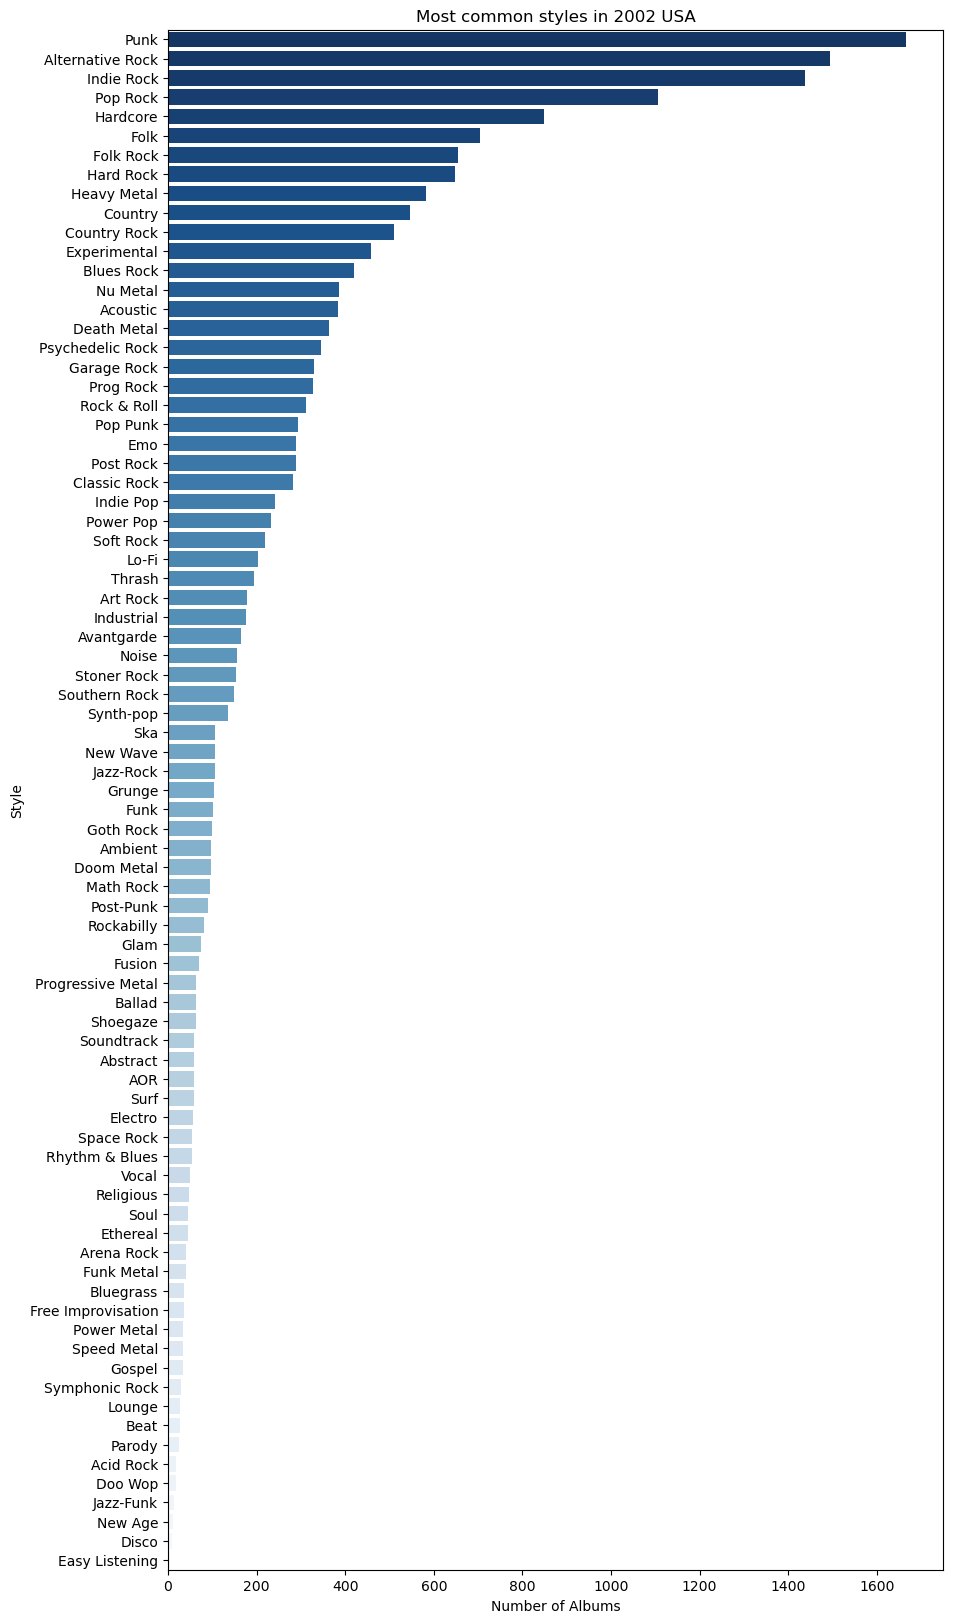

In [ ]:
plt.figure(figsize=(10, 20))
sns.barplot(data=data, y="style", x="albums", palette="Blues_r")
plt.xlabel("Number of Albums")
plt.ylabel("Style")
plt.title("Most common styles in 2002 USA")
plt.show()

## Top 50 styles for all the albums, UK and US

In [ ]:
df = pd.read_csv('Datasets/df_masters_blended.csv')
df['styles'] = df["styles"].apply(ast.literal_eval)
df_styles = df.explode('styles')
top_50_styles = df_styles['styles'].value_counts().head(50).index.to_list()

In [ ]:
df_styles['styles'].value_counts().head(50)

styles
Alternative Rock     2075
Indie Rock           1993
Pop Rock             1314
Hard Rock            1035
Punk                  987
Heavy Metal           976
Prog Rock             824
Hardcore              664
Death Metal           654
Psychedelic Rock      634
Folk Rock             632
Experimental          581
Thrash                482
Art Rock              415
Blues Rock            405
Black Metal           389
New Wave              329
Synth-pop             273
Doom Metal            267
Classic Rock          263
Emo                   255
Acoustic              249
Post-Punk             241
Post Rock             240
Avantgarde            235
Rock & Roll           220
Metalcore             204
Progressive Metal     204
Soft Rock             195
Post-Hardcore         185
Shoegaze              183
Industrial            180
Country Rock          177
Indie Pop             160
Glam                  159
Pop Punk              157
Stoner Rock           146
Speed Metal           146
Garag

In [ ]:
df_styles[df_styles['styles']=='Art Rock'].year.mean()

1993.6722891566264

In [ ]:
df_styles[df_styles['styles']=='Punk']['artist'].count()

987

### **Styles analysis** for number of albums and average year

In [ ]:
# get the average year of each style
top_50_styles = df_styles['styles'].value_counts().head(100)
top_styles = df_styles['styles'].value_counts().head(100).index.to_list()
albums = top_50_styles.values
years = []
styles = []
albums_count = []

for style in top_styles:
    avg_year = int(df_styles[df_styles['styles']==style].year.mean())
    albums = df_styles[df_styles['styles']==style]['artist'].count()
    years.append(avg_year)
    styles.append(style)
    albums_count.append(albums)

df_styles_years = pd.DataFrame({'style': styles, 'albums': albums_count, 'avg_year': years})

In [ ]:
df_styles_years.sort_values('albums', ascending=False).tail(50)

,style,albums,avg_year
50,Fusion,93,1982
51,Grindcore,92,2002
52,Nu Metal,90,2005
53,Ballad,87,1995
54,Electro,86,2007
55,Sludge Metal,82,2009
56,Downtempo,80,2004
57,Goth Rock,78,1994
58,Southern Rock,77,1989
59,Ethereal,74,1999


**Styles Grouping (1960s–2020s Focus)**

**1. Alternative & Indie Rock (80s–2020s)**

✅ Alternative Rock, Indie Rock, Pop Rock, New Wave, Emo, Post Rock, Shoegaze, Indie Pop 

**2. Hard Rock & Metal (70s–2020s)**

✅ Hard Rock, Heavy Metal, Death Metal, Thrash, Black Metal, Doom Metal, Metalcore, Progressive Metal, Stoner Rock, Speed Metal, Nu Metal

**3. Classic & Psychedelic Rock (60s–80s, some revival)**

✅ Prog Rock, Psychedelic Rock, Art Rock, Classic Rock, Space Rock, Symphonic Rock

**4. Punk & Hardcore (70s–2020s)**

✅ Punk, Hardcore, Post-Punk, Post-Hardcore, Pop Punk, Grunge, Garage Rock

**5. Roots Rock & Blues (50s–present)**

✅ Folk Rock, Blues Rock, Rock & Roll, Soft Rock, Country Rock, Southern Rock

**What to Drop? (Even for the 60s–2020s range)**

These styles aren’t really rock in any decade:

❌ Easy Listening, New Age, Free Improvisation, Abstract, Rhythm & Blues, Doo Wop, Soul, Bluegrass, Vocal, Ballad, Jazz-Funk, Disco, Funk

Why? They either:
- Weren’t major parts of the rock genre (Disco, Funk, Soul, R&B, etc.).
- Were independent movements that didn't blend much with rock (New Age, Easy Listening, Jazz-Funk).

In [ ]:
df_styles[df_styles['styles']=='Arena Rock']['artist'].value_counts()

artist
Def Leppard           8
Scorpions             4
Heart                 4
Asia                  4
Journey               4
Dokken                3
Kansas                3
Meat Loaf             3
Uriah Heep            3
Boston                3
Phish                 3
AC/DC                 2
Ratt                  2
Mr. Big               2
Foreigner             2
Magnum                2
Firehouse             2
Europe                2
Queen                 2
REO Speedwagon        2
Triumph               2
Kix                   2
Aerosmith             2
KISS                  1
Frank Zappa           1
The Darkness          1
Roger Waters          1
Deep Purple           1
Survivor              1
Pink Floyd            1
Neil Young            1
Guns N' Roses         1
Joe Satriani          1
Bad Company           1
Yes                   1
Slade                 1
Mr. Mister            1
Praxis                1
Loverboy              1
Simple Minds          1
U2                    1
Andrew W.

In [ ]:
df_styles[df_styles['styles']=='Garage Rock']['artist'].count()

145

In [ ]:
df_styles[df_styles['styles']=='Rockabilly']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
4408,272426,252597,4057583,US,Buddy Holly,Buddy Holly,1958,0.00,12,"['LP', 'Album']","['Rock', 'Pop']",Rockabilly,"American guitarist, singer and songwriter, bes..."
4886,49624,210587,13285348,South Korea,Jeff Beck,Crazy Legs,1993,40.52,18,['Album'],['Rock'],Rockabilly,"British guitarist.\r\nBorn: June 24, 1944, in ..."
5184,272426,183346,1371149,US,Buddy Holly,That'll be the Day,1958,25.15,11,"['LP', 'Album', 'Mono']",['Rock'],Rockabilly,"American guitarist, singer and songwriter, bes..."
6366,27518,107325,4814324,US,Elvis Presley,Elvis Presley,1956,0.00,12,"['LP', 'Album', 'Mono']","['Rock', 'Pop']",Rockabilly,American singer.\r\nBorn: 8 January 1935 in Ea...
7060,253328,83700,900466,Australia,The Living End,State Of Emergency,2006,51.73,14,['Album'],['Rock'],Rockabilly,"Punk rock band from Melbourne, Australia.\r\nF..."
7061,253328,83698,373583,Australia,The Living End,The Living End,1998,47.00,14,['Album'],['Rock'],Rockabilly,"Punk rock band from Melbourne, Australia.\r\nF..."
7320,135946,73462,5780483,US,Johnny Cash,I Walk The Line,1964,32.32,12,"['LP', 'Album', 'Mono']","['Rock', 'Folk, World, & Country']",Rockabilly,"Johnny Cash was an American singer-songwriter,..."
7321,135946,73420,7684728,US,Johnny Cash,The Fabulous Johnny Cash,1958,0.00,12,"['LP', 'Album', 'Mono']","['Rock', 'Folk, World, & Country']",Rockabilly,"Johnny Cash was an American singer-songwriter,..."
7470,180921,69584,1690027,UK,Stray Cats,Stray Cats,1981,0.00,12,"['LP', 'Album']",['Rock'],Rockabilly,The Stray Cats are a rockabilly band first for...
7472,180921,69576,1346627,UK,Stray Cats,Gonna Ball,1981,32.77,11,"['LP', 'Album']",['Rock'],Rockabilly,The Stray Cats are a rockabilly band first for...


# **``album_length``**

In [4]:
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (until 2000) with >= 20 votes 
df = df_masters_blended
df.shape

(9667, 13)

In [5]:
percentage_album_length_missing = round((df['album_length']==0).sum() / df.shape[0] * 100, 2)

print(f"albums missing album_length: {(df['album_length']==0).sum()} ")
print(f'% missing album_length: {percentage_album_length_missing}%')

albums missing album_length: 2234 
% missing album_length: 23.11%


In [6]:
df_length_0 = df[df['album_length']==0].sort_values(['artist', 'year', 'title'])
df_length_0.shape

(2234, 13)

## **``Spotipy`` (Spotify API)**

In [7]:
load_dotenv()

True

In [8]:
user = os.getenv('client_id')
password = os.getenv('client_secret')

# Initialize Spotipy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id = user,
                                                           client_secret = password), requests_timeout=10)

### Testing

In [836]:
count = 0
for artist, title in df_length_0[['artist', 'title']][:10].values:
    count+=1

    print(count, artist, title)

1 ...And You Will Know Us by the Trail of Dead Madonna
2 108 Songs of Separation
3 10cc 10cc
4 10cc Sheet Music
5 10cc Deceptive Bends
6 23 Skidoo Seven Songs
7 2:54 2:54
8 7 Seconds The Crew
9 7 Seconds New Wind
10 A Certain Ratio The Graveyard and The Ballroom


In [8]:
# copy the artist name
artist = 'Agent Orange'

results = sp.search(q = artist
                    , type = 'artist'
                    , limit = 5)

# theorically the artist should be the first result
artist_name = results['artists']['items'][0]['name']
artist_id = results['artists']['items'][0]['id'] # get the artist_id

if artist_name.lower() == artist.lower():
    print(f'artist found: {artist_name}')
else:
    print(f"Cannot find '{artist}', try some other one")

artist found: Agent Orange


In [1025]:
def get_all_albums(artist_id):
    albums = []
    results = sp.artist_albums(artist_id, limit=50)  # First request

    while results:
        albums.extend(results['items'])  # Store the albums
        if results['next']:  # Check if there's another page
            results = sp.next(results)  # Fetch next page
        else:
            break  # Stop when no more pages

    return albums

In [9]:
artist = 'Adam and the Ants'
title = 'Dirk Wears White Sox'
# other albums by the same artist:
# Kings of the Wild Frontier
# Prince Charming

results = sp.search(q = artist
                    , type = 'artist'
                    , limit = 5)

artists = results['artists']['items']
artists_ids = results['artists']['items'] # get the artist_id

for i in range(len(artists)):
    # artist = artists[i]['name']
    try:
        # look for my artist
        if artist.lower().replace('and', '&') == artists[i]['name'].lower():
            # if it finds my artist:
            artist_id = artists_ids[i]['id']
            print('artist found')
            print(artist)

            artist_albums = get_all_albums(artist_id)

            for album in artist_albums:

                print(album['name'])

                # look for my album
                if album['name'].lower().replace('and', '&') == (title.lower().replace('and', '&')):
                    print('album found')
                    album_id = album['id']
                    results = sp.album(album_id)
                    tracks = results['tracks']['items']
                    song_durations = [song['duration_ms']/60000 for song in tracks]
                    
                    album_length = round(sum(song_durations), 2)

                    break   # once it finds the album, stop
    except:
        print('error')            

artist found
Adam and the Ants
error


Here we can see that the album is found, though not on the exact same name, it doesn't do an exact match because there are other parts in the title, such as **'Deluxe Edition'** or **'Remastered'**

In [1078]:
len(artist_albums)

31

In [1082]:
artist_albums[0]['name']

'Kings of the Wild Frontier (Deluxe Edition)'

In [952]:
artist_id

'2jK54ZlZhTF1TxygsVeR05'

### **define the function**

In [973]:
def get_album_length(df):
    count = 0
    scrapped = 0

    # create empty lists
    artists_list = []
    albums_list = []
    albums_lengths = []
    tracks_list = []

    for artist, title in df[['artist', 'title']].values:
        time.sleep(2)
        count+=1

        artists_list.append(artist)
        albums_list.append(title)

        results = sp.search(q = artist
                            , type = 'artist'
                            , limit = 5)

        artists = results['artists']['items']
        artists_ids = results['artists']['items'] # get the artist_id

        for i in range(len(artists)):
            try:
                # look for my artist
                if artist == artists[i]['name']:
                    # if it finds my artist:
                    artist_id = artists_ids[i]['id']

                    # get the albums of the artist
                    results = sp.artist_albums(artist_id, limit=50)
                    data = results['items']

                    # examine all the albums
                    for j in range(len(data)):
                        album = data[j]['name']
                        album_id = data[j]['id']

                    # for album in artist_albums:
                    for j in range(len(data)):
                        album = data[j]['name']
                        album_id = data[j]['id']

                        # look for my album
                        if album.lower() == title.lower():
                            results = sp.album(album_id)
                            tracks = results['tracks']['items']
                            tracks_list.append(len(tracks))
                            song_durations = [song['duration_ms']/60000 for song in tracks]
                            
                            album_length = round(sum(song_durations), 2)
                            albums_lengths.append(album_length)
                            scrapped+=1
                            break   # once it finds the album, stop
                    else:
                        continue
                    break   
            except:
                print('error')
                break
        
        else:
            albums_lengths.append(np.nan)
            tracks_list.append(np.nan)

        print(f"{scrapped}/{count}: {artist} - {title}")

        lists = [artists_list, albums_list, albums_lengths, tracks_list]
        # for lst in lists:
        #     print(len(lst))

    # Check if all lists have the same length
        lengths = [len(lst) for lst in lists]
        if len(set(lengths)) != 1:
            print("Lengths are not the same.")
            break # stop the loop, I won't be able to store the data if I have one value missing

    df_lengths_missing = pd.DataFrame({'artist': artists_list,
                                    'title': albums_list,
                                    'album_length': albums_lengths,
                                    'tracks': tracks_list})
    return df_lengths_missing

In [9]:
def get_all_albums(artist_id):
    albums = []
    results = sp.artist_albums(artist_id, limit=50)  # First request

    while results:
        albums.extend(results['items'])  # Store the albums
        if results['next']:  # Check if there's another page
            results = sp.next(results)  # Fetch next page
        else:
            break  # Stop when no more pages

    return albums

In [10]:
def get_album_length(df):
    count = 0
    scraped = 0

    # create empty lists
    artists_list = []
    albums_list = []
    albums_lengths = []
    tracks_list = []

    for artist, title in df[['artist', 'title']].values:
        time.sleep(1)
        count+=1

        artists_list.append(artist)
        albums_list.append(title)

        results = sp.search(q = artist
                            , type = 'artist'
                            , limit = 5)

        artists = results['artists']['items']
        artists_ids = results['artists']['items'] # get the artist_id

        for i in range(len(artists)):
            artist_name = artists[i]['name'].lower()
            artist_name_and = artist.replace('and', '&').lower()
            try:
                # look for my artist
                if artist_name == artist.lower() or artist_name == artist_name_and:
                    # if it finds my artist:
                    artist_id = artists_ids[i]['id']

                    artist_albums = get_all_albums(artist_id)

                    for album in artist_albums:
                        album_name = album['name'].lower()        
                        title_name_and = title.replace('and', '&').lower()
                        if title.lower() in album_name or title_name_and in album_name:
                            time.sleep(1)
                            album_id = album['id']
                            results = sp.album(album_id)
                            tracks = results['tracks']['items']
                            tracks_list.append(len(tracks))
                            song_durations = [song['duration_ms']/60000 for song in tracks]
                            
                            album_length = round(sum(song_durations), 2)
                            albums_lengths.append(album_length)
                            scraped+=1
                            break   # once it finds the album, stop
                    else:
                        continue
                    break 
            except:
                print('error')
                albums_lengths.append(np.nan)
                tracks_list.append(np.nan)
                break
        
        else:
            albums_lengths.append(np.nan)
            tracks_list.append(np.nan)

        print(f"{scraped}/{count}: {artist} - {title}")

        lists = [artists_list, albums_list, albums_lengths, tracks_list]

    # Check if all lists have the same length
        lengths = [len(lst) for lst in lists]
        if len(set(lengths)) != 1:
            print("Lengths are not the same.")
            break # stop the loop, I won't be able to store the data if I have one value missing

    df_lengths_missing = pd.DataFrame({'artist': artists_list,
                                    'title': albums_list,
                                    'album_length': albums_lengths,
                                    'tracks': tracks_list})
    return df_lengths_missing

### **Get the ``album_length`` from Spotipy**

In [ ]:
start_index = 100
end_index = start_index + 100

df_lengths_missing = get_album_length(df_length_0.iloc[start_index:end_index])
df_lengths_missing.shape

In [2]:
64875/3600

18.020833333333332

In [919]:
minutes = 12.25
attempts = 500

seconds_per_attempt = minutes*60/attempts
seconds_per_attempt 

1.47

In [2]:
df_lengths_missing

NameError: name 'df_lengths_missing' is not defined

### **Exporting to csv**

In [1101]:
df_lengths_missing.to_csv('Datasets/df_lengths_missing_1.csv', index=False)

# **Subgenres**

I will keep the styles, but add another feature called ``subgenres`` to group them and get a better analysis.

**Styles Grouping (1960–2010)**
- **1. Alternative & Indie Rock (80s–2010)**
    - Alternative Rock, Indie Rock, Pop Rock, New Wave, Emo, Post Rock, Shoegaze 
- **2. Hard Rock & Metal (70s–2010)**
    - Hard Rock, Heavy Metal, Death Metal, Thrash, Black Metal, Doom Metal, Metalcore, Progressive Metal, Stoner Rock, Speed Metal, Nu Metal
- **3. Classic & Psychedelic Rock (60s–80s, some revival)**
    - Prog Rock, Psychedelic Rock, Art Rock, Classic Rock, Space Rock, Symphonic Rock
- **4. Punk & Hardcore (70s–2010)**
    - Punk, Hardcore, Post-Punk, Post-Hardcore, Pop Punk, Grunge, Garage Rock
- **5. Roots Rock & Blues (50s–present)**
    - Folk Rock, Blues Rock, Rock & Roll, Soft Rock, Country Rock, Southern Rock

In [44]:
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (until 2000) with >= 20 votes 
df_masters_blended.shape

(9667, 13)

In [45]:
type(df_masters_blended.styles[0]) # each element should be a list

str

In [46]:
df_masters_blended.styles[0]

"['Post-Hardcore']"

In [48]:
# convert these strings to lists
df_masters_blended['styles'] = df_masters_blended["styles"].apply(ast.literal_eval)
df = df_masters_blended.explode('styles')

# now there is only one style per row
df.rename(columns=({'styles': 'style'}), inplace=True)
df.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,style,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],Post-Hardcore,"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],Alternative Rock,"Band from Dover Plains, New York, formerly kno..."
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],Pop Punk,"Band from Dover Plains, New York, formerly kno..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],Blackgaze,"Post-black metal band from Sheffield, UK\r\n\r..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],Post-Hardcore,"Post-black metal band from Sheffield, UK\r\n\r..."


In [49]:
df.shape # before we had 9667 unique albums

(19623, 13)

In [54]:
df.to_csv('Datasets/df_exploded.csv', index=False)

In [31]:
# check the most common styles
df['style'].value_counts().head(25)

style
Alternative Rock    1867
Indie Rock          1847
Pop Rock            1148
Hard Rock            878
Punk                 874
Heavy Metal          715
Prog Rock            661
Hardcore             590
Folk Rock            548
Psychedelic Rock     541
Experimental         473
Art Rock             381
Blues Rock           367
Death Metal          365
Thrash               337
New Wave             293
Classic Rock         245
Emo                  239
Synth-pop            233
Post-Punk            223
Acoustic             205
Rock & Roll          201
Post Rock            201
Doom Metal           180
Avantgarde           176
Name: count, dtype: int64

In [77]:
# These are the styles I got from the US from 1995 until 2010
# I only want to keep these ones in the whole dataset to ensure consistency in the other years (and the whole UK)
styles_to_get = [ 
    "Alternative Rock", "Indie Rock", "Pop Rock", "New Wave", 
    "Emo", "Post Rock", "Shoegaze", "Hard Rock", 
    "Heavy Metal", "Death Metal", "Thrash", "Black Metal", "Doom Metal", 
    "Metalcore", "Progressive Metal", "Stoner Rock", "Speed Metal", "Nu Metal", 
    "Prog Rock", "Psychedelic Rock", "Art Rock", "Classic Rock", "Space Rock", 
    "Symphonic Rock", "Punk", "Hardcore", "Post-Punk", "Post-Hardcore", 
    "Pop Punk", "Grunge", "Garage Rock", "Folk Rock", "Blues Rock", "Rock & Roll", 
    "Soft Rock", "Country Rock", "Southern Rock"
]

In [78]:
df['style'] = df['style'].apply(lambda x: x if x in styles_to_get else np.nan)
df['style'].isna().sum()

134

In [79]:
df.dropna(subset='style', inplace=True)
df.shape

(14658, 14)

So around 25% of the (non-unique) albums had a style that I don't want to keep, so we have significantly reduce the dataset

I dropped styles like: experimental, synth-pop, acoustic, avantgarde, folk, ballad, vocal, soul, jazz-rock...

In [53]:
# check again the most common styles
df['style'].value_counts().head(25)

style
Alternative Rock    1867
Indie Rock          1847
Pop Rock            1148
Hard Rock            878
Punk                 874
Heavy Metal          715
Prog Rock            661
Hardcore             590
Folk Rock            548
Psychedelic Rock     541
Art Rock             381
Blues Rock           367
Death Metal          365
Thrash               337
New Wave             293
Classic Rock         245
Emo                  239
Post-Punk            223
Rock & Roll          201
Post Rock            201
Doom Metal           180
Metalcore            174
Soft Rock            164
Post-Hardcore        160
Country Rock         152
Name: count, dtype: int64

In [80]:
# create lists for every subgenre

indie = ["Alternative Rock", "Indie Rock", "Pop Rock", "New Wave", 
         "Emo", "Post Rock", "Shoegaze"]

metal = ["Hard Rock", "Heavy Metal", "Death Metal", "Thrash", 
         "Black Metal", "Doom Metal", "Metalcore", "Progressive Metal", 
         "Stoner Rock", "Speed Metal", "Nu Metal"]

classic = ["Prog Rock", "Psychedelic Rock", "Art Rock", 
           "Classic Rock", "Space Rock", "Symphonic Rock"]

punk = ["Punk", "Hardcore", "Post-Punk", "Post-Hardcore", 
        "Pop Punk", "Grunge", "Garage Rock"]

roots = ["Folk Rock", "Blues Rock", "Rock & Roll", 
         "Soft Rock", "Country Rock", "Southern Rock"]

# initialize the column
df['subgenre'] = np.nan

In [ ]:
df['subgenre'] = np.where(df['style'].isin(indie), 'indie', df['subgenre'])
df['subgenre'] = np.where(df['style'].isin(metal), 'metal', df['subgenre'])
df['subgenre'] = np.where(df['style'].isin(classic), 'classic', df['subgenre'])
df['subgenre'] = np.where(df['style'].isin(punk), 'punk', df['subgenre'])
df['subgenre'] = np.where(df['style'].isin(roots), 'roots', df['subgenre'])

# sort the columns, place the subgenre next to the styles
list_of_columns = ['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'subgenre', 'style', 'artist_profile']
df = df[list_of_columns]

df.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,subgenre,style,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],punk,Post-Hardcore,"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],indie,Alternative Rock,"Band from Dover Plains, New York, formerly kno..."
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],punk,Pop Punk,"Band from Dover Plains, New York, formerly kno..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],punk,Post-Hardcore,"Post-black metal band from Sheffield, UK\r\n\r..."
3,3398500,3682731,32371239,US,Tiny Moving Parts,Deep in the Blue,2024,0.00,10,"['LP', 'Album', 'Limited Edition']",['Rock'],indie,Emo,"Trio from Benson, Minnesota. The band takes in..."


In [92]:
df['subgenre'].value_counts()

subgenre
indie      5742
metal      3195
punk       2210
classic    2006
roots      1505
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='subgenre'>

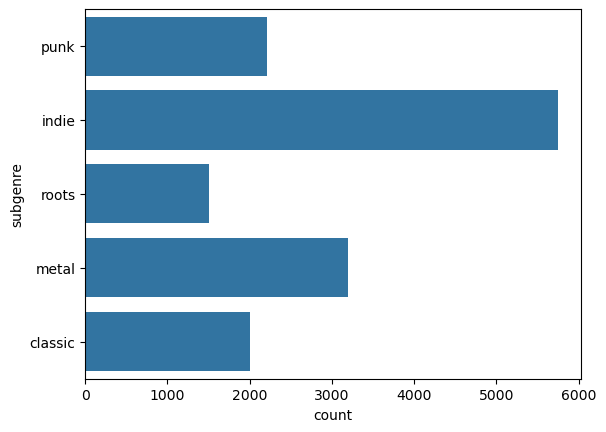

In [83]:
sns.countplot(df['subgenre'])

In [ ]:
# df.to_csv('Datasets/df_exploded.csv', index=False)

In [91]:
df = pd.read_csv('Datasets/df_exploded.csv')
df.shape

(14658, 14)

## **Merge with ``coordinates``**

# **Merge with ``ratings``**

In [86]:
df_masters = df

## **``df_masters`` parenthesis cleaning from ``artist``**

### Testing

I noticed that some artists in df_masters (so, in the Discogs API) have numbers in parenthesis in the artist name, which won't be merged with df_ratings, where there are almost no artists with numbers in parenthesis

In [ ]:
# all the artists in df_masters
df_masters['artist'].nunique()

27045

In [ ]:
# show the artists that have characters in parenthesis in the artist name
df_masters_parenthesis = df_masters[df_masters['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_masters_parenthesis['artist'].nunique()

4816

In [ ]:
# print information
print(f'{df_masters.shape}: df_masters')
print(f'{df_masters_parenthesis.shape}: df_masters_parenthesis')

(15584, 13): df_masters
(656, 13): df_masters_parenthesis


In [ ]:
df_ratings_10['artist'].nunique()

23683

In [ ]:
# show the artists that have characters in parenthesis in the artist name
df_ratings_10_parenthesis = df_ratings_10[df_ratings_10['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_ratings_10_parenthesis['artist'].nunique()

0

In [ ]:
# print information
print(f'{df_ratings_10.shape}: df_ratings_10')
print(f'{df_ratings_10_parenthesis.shape}: df_ratings_10_parenthesis')

(79632, 5): df_ratings_top
(1760, 5): df_ratings_top_parenthesis


In [ ]:
df_ratings_10_parenthesis.sample(5)

,album_id,artist,title,rating,votes
66859,299052,Vacations (AUS),Vibes and Days,3.87,15
66521,293448,Carnation (BE),Chapel of Abhorrence,3.35,40
34007,67551,Soundtrack (Video Game),The Legend of Zelda: Twilight Princess OST,4.23,80
39072,84542,Doom (JPN),Complicated Mind,4.16,25
36362,74638,Tempest (Can),Passages,3.73,37


In most of the artists, the information between parenthesis is the country of origin

In [ ]:
# delete these characters
df_masters_parenthesis_clean = df_masters_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_masters_parenthesis_clean

2364       100% Proof
3971       100% Proof
2622     20/20 Vision
1164       38 Special
2445       38 Special
            ...      
3727              XIT
3045            Ya Ya
1735    Youth In Asia
3931              ZED
599              Zeno
Name: artist, Length: 656, dtype: object

In [ ]:
# delete these characters
df_ratings_10_parenthesis_clean = df_ratings_10_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_ratings_10_parenthesis_clean

52533                  
53599                  
35534    Slowest Runner
35487    Slowest Runner
13266              p.e.
              ...      
39716              hide
68464              life
70926              life
49438              sway
68857              オオハシ
Name: artist, Length: 1760, dtype: object

In [ ]:
# merge test, all the artists that coincide on both dataframes after the parenthesis cleaning
pd.merge(df_masters_parenthesis_clean, df_ratings_10_parenthesis_clean, on='artist')

,artist
0,Alaska
1,Alaska
2,Alaska
3,Alaska
4,Attila
...,...
123,X
124,X
125,X
126,X


In [ ]:
df_masters[df_masters['artist'].str.contains('Alaska ')]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
1516,594810.0,309057.0,2702245,US,Alaska (8),The Pack,1985,42.32,9,"['LP', 'Album', 'Stereo']",['Rock'],['Hard Rock'],Alaska was a British hard rock band led by Ber...
2990,594810.0,591189.0,1175493,UK,Alaska (8),Heart Of The Storm,1984,0.00,10,"['LP', 'Album']",['Rock'],"['Hard Rock', 'AOR']",Alaska was a British hard rock band led by Ber...


In [ ]:
df_ratings_10[df_ratings_10['artist'].str.contains('Alaska ')]

,album_id,artist,title,rating,votes
48864,135438,Alaska (USA),Everything is Fine,3.38,12
57915,203926,Alaska (USA),Shrine,3.54,12


This shows that for instance **the artist 'Zebra' would not have merged** if we hadn't done that cleaning, because in ``df_masters`` it's registered under **"Zebra (8)"**, and in ``df_ratings`` under **"Zebra (US)"**

### **Let's change the ``artist`` column for good**

In [ ]:
df_masters.shape

(37597, 13)

In [ ]:
df_masters['artist'] = df_masters['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"{df_masters['artist'].nunique()} unique artists in df_masters")

28995 unique artists in df_masters


In [ ]:
df_ratings_20['artist'] = df_ratings_20['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"{df_ratings_20['artist'].nunique()} unique artists in df_ratings_20")

14837 unique artists in df_ratings_20


## **&/and Cleaning**

I noticed some artist and/or album names are slightly different, which will cause the merge to not properly function as I intend it.

Notice the difference in the following album: "Behold **and/&** See"

In [ ]:
df_ratings_20[df_ratings_20['artist']=="Ultimate Spinach"]

,album_id,artist,title,rating,votes
34041,136113,Ultimate Spinach,Ultimate Spinach,3.81,27
35157,150508,Ultimate Spinach,Behold and See,3.89,23


In [ ]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [ ]:
df_masters[['artist', 'title']] = df_masters[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))
df_ratings_20[['artist', 'title']] = df_ratings_20[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))

In [ ]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


## Actual merge

In [88]:
df = pd.merge(
    df_ratings_20.assign(artist_lower=df_ratings_20['artist'].str.lower().str.strip(), 
                      title_lower=df_ratings_20['title'].str.lower().str.strip()), 
    df_masters.assign(artist_lower=df_masters['artist'].str.lower().str.strip(), 
                      title_lower=df_masters['title'].str.lower().str.strip()), 
    on=['artist_lower', 'title_lower']
).drop(columns=['artist_lower', 'title_lower', 'artist_y', 'title_y'])

# Rename columns
df.rename(columns={'artist_x': 'artist', 'title_x': 'title'}, inplace=True)

# Change dtypes
df['master_id'] = df['master_id'].astype(int)

# print the shape
df.shape

(14657, 17)

In [89]:
df[df['artist']=='Bob Dylan and The Band']

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,subgenre,style,artist_profile


In [90]:
df.sample(5)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,subgenre,style,artist_profile
9531,58133,Girls Against Boys,Cruise Yourself,3.60,25,56262,20621,1144517,US,1994,40.98,11,['Album'],['Rock'],indie,Indie Rock,US indie rock/post-hardcore band formed in Was...
12726,211418,Asking Alexandria,The Black,2.59,503,2021935,984360,8288217,USA & Europe,2016,47.67,12,['Album'],['Rock'],metal,Metalcore,British metal band formed in 2008 after the di...
1435,3002,Joe Satriani,The Extremist,4.17,265,76588,37983,1988907,US,1992,47.52,10,"['Album', 'Stereo']",['Rock'],metal,Hard Rock,"US hard rock guitarist.\r\nBorn: July 15, 1956..."
1200,2389,Pink Floyd,Obscured By Clouds,3.46,1456,45467,14720,3092412,UK,1972,0.00,10,"['LP', 'Album', 'Stereo']","['Rock', 'Stage & Screen']",classic,Psychedelic Rock,Pink Floyd was an English rock band from Londo...
7286,30154,Onslaught,The Force,4.06,120,266105,114492,1792623,UK,1986,46.02,7,"['LP', 'Album']",['Rock'],metal,Thrash,Formed as a hardcore punk band in the early 19...


In [ ]:
df['release_country'].value_counts().head(10)

release_country
US              2314
Europe           318
Germany          186
UK                38
Sweden            38
USA & Canada      36
France            29
Canada            29
Australia         28
Netherlands       27
Name: count, dtype: int64

In [ ]:
print(f"{round(df.shape[0] / df_masters.shape[0]*100, 2)} % of the albums have more than 20 votes")

8.69 % of the albums have more than 20 votes


### First inspection

**Change the dtype of ``artist_id``**

In [ ]:
df[df['artist_id'].isna()]

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile


In [ ]:
df[df['artist']=='Meshuggah'].sample(3)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
2465,96456,Meshuggah,Koloss,3.75,1940,252273.0,421823,3498596,Germany,2012,54.78,10,['Album'],['Rock'],"['Thrash', 'Death Metal', 'Progressive Metal',...","Swedish progressive metal band from Umeå, whic..."
61,457,Meshuggah,Nothing,3.99,1754,252273.0,14397,386915,Germany,2002,53.07,10,"['Album', 'Enhanced']",['Rock'],"['Thrash', 'Experimental']","Swedish progressive metal band from Umeå, whic..."
62,457,Meshuggah,Nothing,3.99,1754,NaN,0,2223511,US,2002,53.10,10,"['Album', 'Enhanced']",['Rock'],"['Thrash', 'Experimental']",NaN


In [ ]:
df.loc[62, 'artist_id'] = 252273

In [ ]:
df['artist_id'] = df['artist_id'].astype(int)
df.head(1)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,53,Dream Theater,Train of Thought,3.87,2670,260935,52100,432029,US,2003,69.35,7,"['Album', 'Enhanced']",['Rock'],"['Progressive Metal', 'Symphonic Metal']","American progressive metal band, formed in Bos..."


**Sort columns**

I want to see the ``year`` next to the album ``title``, and I don't care much about the ``ids``

In [ ]:
df = columns_show_ratings(df)
df.head(1)

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
0,53,Dream Theater,Train of Thought,2003,3.87,2670,69.35,7,US,"['Album', 'Enhanced']",['Rock'],"['Progressive Metal', 'Symphonic Metal']","American progressive metal band, formed in Bos...",260935,52100,432029


**I keep only rock albums**

In [ ]:
# how many of them are Rock albums?
print(f"Rows before dropping: {df.shape[0]}")
df = df[df['genres'].str.contains('Rock')]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3269
Rows after dropping: 3269


**Drop compilations**

In [ ]:
df['release_type'].isna().sum()

0

In [ ]:
df['release_type'].value_counts().head(10)

release_type
['Album']                             2031
['LP', 'Album']                        312
['Album', 'Enhanced']                  152
['LP', 'Album', 'Limited Edition']     102
['Album', 'Stereo']                     93
['Album', 'Limited Edition']            54
['LP', 'Album', 'Stereo']               41
['FLAC', 'Album']                       40
['MP3', 'Album']                        29
['LP']                                  27
Name: count, dtype: int64

In [ ]:
df[df['release_type'].isna()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [ ]:
df.loc[1230, 'release_type']

"['Album']"

In [ ]:
df.loc[1229, 'release_type'] = 'Album'
df.loc[8799, 'release_type'] = 'Album'

In [ ]:
df['release_type'].isna().sum()

0

In [ ]:
print(df['release_type'].dtype)

object


In [ ]:
type(df.release_type[0])

str

In [ ]:
print(f'There are {df[df['release_type'].str.contains('Compilation')].shape[0]} compilations')

There are 0 compilations


In [ ]:
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['release_type'].str.contains('Compilation')]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3269
Rows after dropping: 3269


In [ ]:
# number of unique artists
df['artist'].nunique()

2204

**YOB** té **8** albums a Sputnik (``df_ratings_20``), però nomes **2** a Discogs de UK, tot i que és una banda de UK. 

Si apareixen al df de US, hauré de fer un concat/merge

In [ ]:
df[df['artist']=='YOB']

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
479,3646,YOB,The Illusion Of Motion,2004,3.94,183,56.37,4,Germany,['Album'],['Rock'],"['Stoner Rock', 'Doom Metal']",Yob is an American stoner/doom metal band from...,563922,129478,1119948
1878,29146,YOB,The Unreal Never Lived,2005,4.06,225,51.80,4,US,['Album'],['Rock'],['Doom Metal'],Yob is an American stoner/doom metal band from...,563922,129479,732137
2328,60240,YOB,Elaborations Of Carbon,2002,3.42,73,70.12,6,US,['Album'],['Rock'],['Doom Metal'],Yob is an American stoner/doom metal band from...,563922,577362,1593094
2696,282109,YOB,Our Raw Heart,2018,3.87,295,73.27,7,US,"['FLAC', 'Album']",['Rock'],"['Doom Metal', 'Sludge Metal']",Yob is an American stoner/doom metal band from...,563922,1374548,13688747


In [ ]:
df_ratings_20[df_ratings_20['artist']=='YOB']

,album_id,artist,title,rating,votes
2483,3646,YOB,The Illusion Of Motion,3.94,183
15489,29146,YOB,The Unreal Never Lived,4.06,225
19314,39606,YOB,The Great Cessation,3.90,205
24379,60240,YOB,Elaborations Of Carbon,3.42,73
24380,60241,YOB,Catharsis,3.99,140
28069,80046,YOB,Atma,3.78,259
36250,163668,YOB,Clearing The Path To Ascend,3.92,331
43343,282109,YOB,Our Raw Heart,3.87,295


## **``df`` real cleaning**

I want to **drop duplicates** and releases from **bands outside of the UK and the US**, I only want to keep brittish and american artists. Also **drop compilations and live albums**.

### **Drop duplicates**

**``master_id = 0``**

In [ ]:
df.sort_values('master_id', inplace=True, ascending=False) # so I keep the master_id=0 at the end, these would be the duplicates and I'll be able to drop them
df.reset_index(drop=True, inplace=True)
df[['album_id', 'artist', 'title', 'year', 'rating', 'votes', 'album_length', 'tracks']].duplicated().sum()

5

In [ ]:
# these albums are the same, except one entry has master_id=0
print(f"Rows before dropping: {df.shape[0]}")
df.drop_duplicates(subset=['artist', 'title', 'year', 'rating', 'votes', 'album_length', 'tracks'], inplace=True)
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3269
Rows after dropping: 3264


**``album_length = 0``**

In [ ]:
df.sort_values('album_length', inplace=True, ascending=False) # so I keep the album_length=0 at the end, these would be the duplicates and I'll be able to drop them
df.reset_index(drop=True, inplace=True)
df[['album_id', 'artist', 'title', 'year', 'rating', 'votes']].duplicated().sum()

12

In [ ]:
df[df[['album_id', 'artist', 'title', 'year', 'rating', 'votes']].duplicated()]['album_length'].value_counts()

album_length
0.00     6
56.28    1
53.07    1
45.42    1
41.35    1
36.30    1
13.27    1
Name: count, dtype: int64

In [ ]:
# most of these albums are the same, except one entry has album_length=0
print(f"Rows before dropping: {df.shape[0]}")
df.drop_duplicates(subset=['artist', 'title', 'year', 'rating', 'votes'], inplace=True)
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3264
Rows after dropping: 3252


**duplicates by ``artist`` and ``title``**

In [ ]:
df[df[['artist', 'title']].duplicated()].head()

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
464,15873,Days of the New,Days of the New,2001,3.70,157,56.92,13,US,['Album'],['Rock'],"['Alternative Rock', 'Grunge', 'Acoustic']",Days of the New is an American rock band from ...,85890,659503,1291898
1147,193607,Cattle Decapitation,The Anthropocene Extinction,2020,3.91,777,46.23,12,US,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Death Metal', 'Grindcore']",American grindcore/death metal band based in S...,388407,0,15816188
1275,102755,The Contortionist,Intrinsic,2020,3.38,1024,45.12,11,US,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Progressive Metal', 'Death Metal', 'Math Rock']",The Contortionist is an American progressive m...,1964016,0,17467792
1432,11604,Black Label Society,Shot to Hell,2020,2.98,261,43.67,13,US,"['LP', 'Album']",['Rock'],['Heavy Metal'],American heavy metal band formed in 1998 in Lo...,299863,0,31008001
1497,13296,Nonpoint,Development,0,3.27,113,42.92,12,US,"['Album', 'Reissue']","['Hip Hop', 'Rock']",['Nu Metal'],Nonpoint is an American heavy metal band from ...,264928,534163,1407838


In [ ]:
df[['artist', 'title']].duplicated().sum()

20

In [ ]:
df[df['title']=='Days of the New	'.strip()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
296,15873,Days of the New,Days of the New,1999,3.7,157,62.25,14,US,['Album'],['Rock'],"['Alternative Rock', 'Grunge', 'Acoustic']",Days of the New is an American rock band from ...,85890,447101,435592
464,15873,Days of the New,Days of the New,2001,3.7,157,56.92,13,US,['Album'],['Rock'],"['Alternative Rock', 'Grunge', 'Acoustic']",Days of the New is an American rock band from ...,85890,659503,1291898


**Drop incorrect albums**

In [ ]:
# check one by one if necessary
try:
    df.drop([12027], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")

Rows dropped
(12004, 16)


**Change specific values that are wrong/missing**

In [ ]:
# change specific values that are wrong/missing

# df.loc[9591, 'title'] = 'Santana III'
# df.loc[9591, 'rating'] = 4.26
# df.loc[9591, 'votes'] = 227
df.loc[4695, 'album_length'] = 30.25
# df.loc[3286, 'tracks'] = 15
# df.loc[9575, 'year'] = 1996

In [ ]:
# calculate the decimals of the album length (seconds)
29/60

0.48333333333333334

**``df_ratings_top``**

If there are two albums with the same name, but one is for instance an EP or a compilation I don't want to keep, I have to drop it from df,

but also from ``df_ratings_top``, otherwise I will keep running into this duplicated album every time I add more albums

In [ ]:
df_ratings_20[df_ratings_20['artist']=='Pepper'.strip()]

,album_id,artist,title,rating,votes
2436,3581,Pepper,Kona Town,3.87,114
2708,3970,Pepper,In With The Old,3.46,61
8649,14537,Pepper,No Shame,3.34,79
15291,28637,Pepper,Pink Crustaceans and Good Vibrations,3.26,40
16813,32335,Pepper,Give'n It,3.22,20
33650,130639,Pepper,Pepper,2.52,21


In [ ]:
# check one by one if necessary
try:
    df_ratings_20.drop([4051], axis=0, inplace=True)
    print('Rows dropped')
    print(df_ratings_20.shape)
except:
    print("Couldn't drop these rows")

Rows dropped
(51240, 5)


In [ ]:
df_ratings_20.to_csv('Datasets/df_ratings_20.csv', index=False)

### **Drop live albums**

**Hauré d'eliminar tmb albums de 'MTV Unplugged'**

Let's try to detect the live albums by the title

#### **'Live at'**

In [ ]:
df.shape

(3252, 16)

In [ ]:
print(f"There are {df[df['title'].str.contains('Live at ', case=False)].shape[0]} albums with 'Live at ' in the title")

There are 9 albums with 'Live at ' in the title


In [ ]:
# Let's check them before deleting them
df[df['title'].str.contains('Live at ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
4,2155,Coheed and Cambria,Live at the Starland Ballroom,2005,4.19,264,205.03,36,US,"['NTSC', 'Album']",['Rock'],"['Alternative Rock', 'Emo', 'Prog Rock']",A progressive rock band based out of Nyack and...,256629,819727,6761981
8,998,Dream Theater,Live at Budokan,2004,4.12,366,165.35,18,US,['Album'],['Rock'],"['Progressive Metal', 'Symphonic Metal']","American progressive metal band, formed in Bos...",260935,52737,835823
41,1532,Jimi Hendrix,Live at Woodstock,1999,4.40,195,96.50,16,Europe,"['Album', 'Remastered']",['Rock'],['Psychedelic Rock'],American modern electric blues guitar virtuoso...,110593,251465,1035861
127,18329,Rage Against the Machine,Live at the Grand Olympic Auditorium,2003,3.77,272,71.02,16,US,['Album'],"['Hip Hop', 'Rock', 'Funk / Soul']","['Hard Rock', 'Alternative Rock', 'Hardcore', ...",Alternative / funk / modern rock band formed i...,12212,92111,368202
190,94660,Neil Young,Live at Massey Hall 1971,2007,4.43,147,67.52,17,US,"['HDCD', 'Album', 'Stereo']",['Rock'],"['Country Rock', 'Southern Rock', 'Acoustic']",Neil Young is a Canadian-American singer-songw...,138556,38727,2305420
191,73273,The Jimi Hendrix Experience,Live At Berkeley,2003,4.25,26,67.47,12,US,['Album'],['Rock'],"['Psychedelic Rock', 'Classic Rock']",The Jimi Hendrix Experience (often shortened t...,255672,82849,1335394
275,8991,Eels,Eels With Strings - Live At Town Hall,2006,3.90,40,63.08,22,Europe,['Album'],['Rock'],['Indie Rock'],US alternative rock band formed in 1995 by sin...,74395,117733,630958
2552,1618,Incubus,Alive at Red Rocks,2004,4.23,224,21.95,24,US,"['DVD-Video', 'Multichannel', 'NTSC', 'Album']",['Rock'],"['Alternative Rock', 'Funk Metal']",Alternative Rock band (formerly Funk Metal & N...,149192,59255,9364072
3210,6864,Clutch,Live At The Googolplex,2003,3.52,25,0.00,15,US,['LP'],['Rock'],['Stoner Rock'],Clutch is an American Rock band that started d...,289116,184641,5418192


In [ ]:
# correct, they are all live albums
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains('Live at ', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3252
Rows after dropping: 3243


#### **'Live in'**

In [ ]:
print(f"There are {df[df['title'].str.contains(r'^Live in ', case=False)].shape[0]} albums with 'Live in ' in the title")

There are 6 albums with 'Live in ' in the title


In [ ]:
# Let's check them before deleting them
df[df['title'].str.contains(r'^Live in ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
29,2447,Linkin Park,Live In Texas,2003,3.23,489,108.68,29,Europe,"['Album', 'Enhanced']",['Rock'],['Nu Metal'],"Alternative rock band from Agoura Hills, Calif...",40029,74531,383474
185,655,Strung Out,Live in a Dive,2003,4.38,53,68.07,21,US,['Album'],['Rock'],['Punk'],"American punk rock band from Simi Valley, Cali...",253310,287638,1146384
212,50617,Testament,Live in London,2005,4.29,49,66.12,14,US,['Album'],['Rock'],['Thrash'],Thrash Metal (Heavy Metal) band from San Franc...,137126,281150,896926
2788,375463,King Gizzard and The Lizard Wizard,Live In San Francisco '16,2020,4.19,26,0.00,13,Australia,"['LP', 'Limited Edition']",['Rock'],['Psychedelic Rock'],"Psychedelic rock band from Melbourne, Victoria...",2532180,1841534,16522995
2864,11810,Lagwagon,Live In A Dive,2005,4.05,53,0.00,22,US,['LP'],['Rock'],['Punk'],American punk rock band originally named [a=Se...,253308,246514,1485031
2947,24160,Joan of Arc,"Live In Chicago, 1999",1999,3.59,23,0.00,13,US,['LP'],['Rock'],"['Post Rock', 'Indie Rock']","Chicago, IL-based indie/experimental outfit. ...",279142,148862,740028


In [ ]:
# I can drop them all
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains(r'^...Live in ', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3243
Rows after dropping: 3235


In [ ]:
# This is a studio album
df[df['title'].str.contains('Live in ', case=True)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


#### **'MTV Unplugged'**

In [ ]:
print(f"There are {df[df['title'].str.contains(r'MTV Unplugged', case=False)].shape[0]} albums with 'MTV Unplugged' in the title")

There are 0 albums with 'MTV Unplugged' in the title


In [ ]:
# Let's check them before deleting them
df[df['title'].str.contains(r'MTV Unplugged', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [ ]:
# I can drop them all
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains(r'MTV Unplugged', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3235
Rows after dropping: 3235


### **Drop compilations sorting albums by the top rated**

#### **'Greatest Hits'**

In [ ]:
print(f"There are {df[df['title'].str.contains(r'Greatest Hits', case=False)].shape[0]} albums with 'Greatest Hits' in the title")

There are 1 albums with 'Greatest Hits' in the title


In [ ]:
# Let's check them before deleting them
df[df['title'].str.contains(r'Greatest Hits', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
1759,56010,Alien Ant Farm,Greatest Hits,1999,3.22,37,40.32,10,US,['Album'],['Rock'],"['Alternative Rock', 'Garage Rock', 'Hard Rock...",American alternative rock / modern rock band t...,152509,581207,3402074


In [ ]:
# I can drop them all
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains(r'Greatest Hits', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3235
Rows after dropping: 3234


#### **Sorting by the top rated and most rated**

Usually compilations have the best songs of the band and users love them, so let's find them, even if 'Compilation' is not in ``release_type``

In [ ]:
start_row = 50

df.sort_values(['rating', 'votes'], ascending=False).iloc[start_row:start_row+10]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
470,16873,Disillusion,Back to Times of Splendor,2004,4.26,611,56.83,6,US,['Album'],['Rock'],"['Progressive Metal', 'Power Metal', 'Melodic ...",Melodic progressive death metal outfit from Le...,388646,413839,6499044
154,125094,Gustavo Cerati,Bocanada,1999,4.26,90,69.35,15,Argentina,['Album'],"['Electronic', 'Rock', 'Pop']","['Alternative Rock', 'Art Rock', 'Dream Pop', ...","Born: August 11, 1959, Buenos Aires, Argentina...",170488,917996,10402046
1769,17023,Os Mutantes,A Divina Comédia ou Ando Meio Desligado,1970,4.25,61,40.23,11,Brazil,"['LP', 'Album', 'Mono']","['Rock', 'Latin']","['Psychedelic Rock', 'MPB']",Pop trio from Brazil. \r\n\r\nFormed in the la...,15161,54517,2823527
755,845,Wilco,Yankee Hotel Foxtrot,2002,4.24,1675,51.57,11,Europe,"['LP', 'Album', 'Stereo']",['Rock'],"['Alternative Rock', 'Country Rock']",American alternative rock band formed in 1994 ...,102984,10363,4426525
78,18071,Weakling,Dead as Dreams,2000,4.24,537,76.15,5,US,['Album'],['Rock'],['Black Metal'],"American black metal band from San Francisco, ...",251627,196126,9926322
3076,2350,The Weakerthans,Reconstruction Site,2003,4.24,521,0.00,14,USA & Canada,"['LP', 'Album']",['Rock'],"['Emo', 'Punk']","Punk influenced band from Winnipeg, Canada, fo...",283746,204263,2030928
56,18044,The Arrogant Sons of Bitches,Three Cheers For Disappointment,2006,4.24,485,79.28,44,US,"['Enhanced', 'Album']",['Rock'],"['Ska', 'Punk']",The Arrogant Sons of Bitches (commonly abbrevi...,1690973,401846,3349754
3165,22185,Trespassers William,Different Stars,2002,4.24,299,0.00,11,US,['Album'],['Rock'],"['Folk Rock', 'Lo-Fi', 'Ethereal']","Line-ups :\r\n1999-2001 : Anna-Lynne Williams,...",283740,127194,516231
3096,3146,Blind Guardian,Live,2003,4.24,143,0.00,27,NaN,"['LP', 'Album', 'Picture Disc']",['Rock'],['Heavy Metal'],"Power/heavy metal band from Krefeld, Nordrhein...",262577,198529,2592998
139,6394,Drive-By Truckers,The Dirty South,2004,4.24,114,70.33,14,US,"['Album', 'Stereo']",['Rock'],['Southern Rock'],Alternative country/Southern rock band based i...,493270,188892,1094881


In [ ]:
# check one by one if necessary
try:
    df.drop([3433], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(11952, 16)


**drop albums also from ``df_ratings_top``** if they are live albums, compilations, bands from outside the UK or US...

In [ ]:
df_ratings_20[df_ratings_20['artist']=="Ulver".strip()]

,album_id,artist,title,rating,votes


In [ ]:
# check one by one if necessary
try:
    df_ratings_20.drop([7066], axis=0, inplace=True)
    print('Rows dropped')
    print(df_ratings_20.shape)
except:
    print("Couldn't drop these rows")

Rows dropped
(51221, 5)


**Drop one artist**

In [ ]:
print(f"Rows before dropping: {df_ratings_20.shape[0]}")
df_ratings_20 = df_ratings_20[df_ratings_20['artist']!="Satyricon".strip()]
print(f"Rows after dropping: {df_ratings_20.shape[0]}")

Rows before dropping: 51158
Rows after dropping: 51144


**export again to .csv**

In [ ]:
df_ratings_20.to_csv('Datasets/df_ratings_20.csv', index=False)

### **``year = 0``**

In [ ]:
df[df['year']==0].shape

(12, 16)

In [ ]:
df[df['year']==0].head()

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
11753,6042,Death Cab for Cutie,Something About Airplanes,0,3.52,440,43.3,10,US,"['Album', 'Reissue']",['Rock'],['Indie Rock'],"American indie rock band formed in Bellingham,...",280098,3443,409339


In [ ]:
df.loc[11753, 'year'] = 1998

In [ ]:
# check one by one if necessary
try:
    df.drop([9935], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(11941, 16)


**Drop one artist**

In [ ]:
print(f"Rows before dropping: {df.shape[0]}")
df = df[df['artist']!="Satyricon".strip()]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 11922
Rows after dropping: 11920


### **Drop ratings and sort columns**

In [ ]:
df = columns_hide_ratings(df)

In [ ]:
df_masters.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,514808.0,3666645,3503643,US,Black 47,Live In New York City,1999,67.2,12,['Album'],['Rock'],['Alternative Rock'],Black 47 was an American Celtic rock band from...


In [ ]:
df.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,255680,267825,1911585,Europe,Eagles,Eagles,2005,325.5,84,['Album'],['Rock'],"['Country Rock', 'Classic Rock']",American rock band founded in 1971 by [a=Glenn...


In [ ]:
df['artist'].nunique()

2202

In [ ]:
df['artist_id'] = df['artist_id'].astype(int)

### **Export to csv**

In [ ]:
df.to_csv('Datasets/df_us_new_masters_clean.csv', index=False)

<Axes: xlabel='count', ylabel='year'>

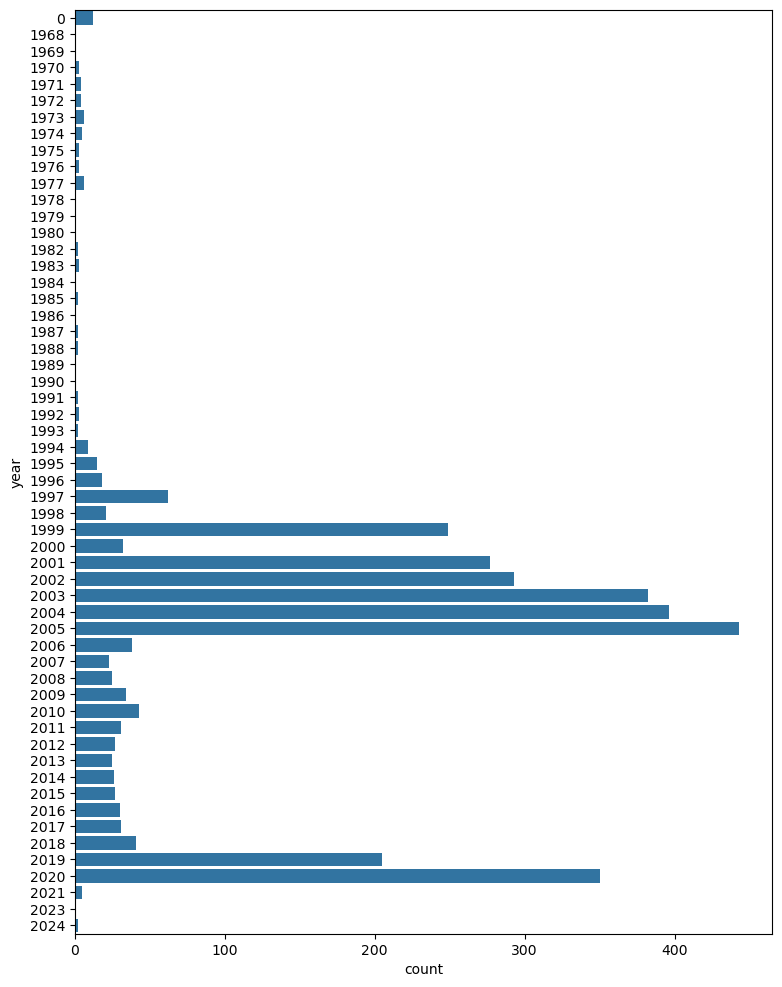

In [ ]:
plt.figure(figsize=(9,12))
sns.countplot(data=df, y='year')